### Packages and Settings

In [ ]:
%load_ext nb_black
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import sys
import os
import gc
import random
import pickle
from more_itertools import consecutive_groups
from ipywidgets import interact, fixed, IntSlider
import subprocess


np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 200)
sys.path = sys.path + ["/home/qlyang/Documents/pacman/"]

from helper.utiltools import eval_df
from helper.pacmanutils import (
    rt_df_filter,
    generate_local_4dirs,
    relative_dir,
    largest_2ndlargest_diff,
    to_game,
    if_get_nearbean,
    assign_category,
    combine_pre_post,
    add_stats,
    add_combine_huntdis,
    generate_simulated_local_4dirs,
    get_marker,
    plot_ghost,
    plot_colors_simple,
)

from helper.add_features import add_dis, add_move_dir
from helper.constant_input import (
    OPPOSITE_DIRS,
    MAP_INFO,
    TURNING_POS,
    LOCS_DF,
    POSSIBLE_DIRS,
    SYMBOLS,
    ARRAY,
)
from helper.analysis import status_index

from ipywidgets import interact, fixed
import ipywidgets as widgets

def add_nearby_bean(df):
    df_temp = add_dis(
        df[["file", "index", "pacmanPos"]].merge(
            df[["file", "index", "beans"]].explode("beans"),
            on=["file", "index"],
            how="left",
        ),
        "pacmanPos",
        "beans",
    )
    return df.merge(
        df_temp[df_temp.dis <= 5]
        .groupby(["file", "index"])
        .size()
        .rename("nearby_bean_cnt")
        .reset_index(),
        how="left",
        on=["file", "index"],
    )


# local>0.9是local；global>0.9是global
# pess>0.3 && Not(local or global)
# Attack>0.3 && Not(local or global)
# Suicide>0.3 && Not(local or global)
# Vague: |local&global-0.5|<0.4 && not (Pess, Attack,Suicide)
# global, local, pessimistic, suicide, planned_hunting


def global_local_trans(x, thr):
    if isinstance(x, float):
        return None
    if x[0] > 0.0001 and x[1] > 0.0001:
        if x[0] / np.sqrt(sum(x ** 2)) >= thr:
            return "global_larger"
        elif x[1] / np.sqrt(sum(x ** 2)) >= thr:
            return "local_larger"
        elif x[2] / np.sqrt(sum(x ** 2)) > 0.3:
            return "evade"
        elif x[4] / np.sqrt(sum(x ** 2)) > 0.3:
            return "energizer"
        elif x[3] / np.sqrt(sum(x ** 2)) > 0.3:
            return "approach"
        elif (
            x[1] / np.sqrt(sum(x ** 2)) > 1 - thr
            and x[1] / np.sqrt(sum(x ** 2)) < thr
            and x[0] / np.sqrt(sum(x ** 2)) > 1 - thr
            and x[0] / np.sqrt(sum(x ** 2)) < thr
        ):
            return "vague"
        else:
            return None


def local_attack_trans(x):
    if isinstance(x, float):
        return None
    if x[0] > 0.0001 and x[1] > 0.0001:
        if x[1] > x[4]:
            return "local_larger"
        elif x[1] < x[4]:
            return "attack_larger"
        else:
            return None


def trans_plot(df_reset, before_status, after_status, value_col):
    if before_status in ["evade_larger", "suicide_larger"]:
        compare_col = "es_trans"
    elif before_status in ["local_larger", "global_larger"]:
        compare_col = "gl_trans"
    else:
        compare_col = "la_trans"
    before_cons = [
        j
        for j in [
            list(i)
            for i in consecutive_groups(
                df_reset[compare_col].where(lambda x: x == before_status).dropna().index
            )
        ]
        if len(j) >= 3
    ]
    after_cons = [
        j
        for j in [
            list(i)
            for i in consecutive_groups(
                df_reset[compare_col].where(lambda x: x == after_status).dropna().index
            )
        ]
        if len(j) >= 3
    ]
    before_to_after = pd.DataFrame(
        [before_cons, [i[-1] + 1 for i in before_cons]]
    ).T.merge(
        pd.DataFrame([[i[0] for i in after_cons], after_cons]).T, left_on=1, right_on=0,
    )
    pd.concat(
        [
            before_to_after["0_x"].apply(
                lambda x: pd.Series(
                    df_reset.loc[x[-5:], value_col].values, index=np.arange(-5, 0)
                )
            ),
            before_to_after["1_y"].apply(
                lambda x: pd.Series(
                    df_reset.loc[x[:5], value_col].values, index=np.arange(0, 5)
                )
            ),
        ],
        1,
    ).mean().plot()


def confu_mat_per_file(x, col):
    return (
        pd.concat([x[col].rename("after"), x[col].shift(1).rename("before")], 1)
        .dropna()
        .groupby(["before", "after"])
        .size()
    )


def add_states(df_reset):
    df_tmp = pd.DataFrame(
        [
            [np.nan] * 5 if isinstance(i, float) else i
            for i in df_reset.contribution.to_list()
        ],
        columns=["global", "local", "evade", "approach", "energizer"],
    )

    vague_mask = (
        np.sort(df_tmp.divide(np.sqrt(df_tmp.sum(1) ** 2), 0).values)[:, -1]
        - np.sort(df_tmp.divide(np.sqrt(df_tmp.sum(1) ** 2), 0).values)[:, -2]
    ) <= 0.1

    nan_mask = df_tmp.fillna(0).sum(1) == 0

    return pd.concat(
        [
            df_reset,
            pd.Series(
                [
                    ["global", "local", "evade", "approach", "energizer"][i]
                    for i in df_tmp.values.argsort()[:, -1]
                ]
            )
            .mask(vague_mask)
            .fillna("vague")
            .mask(nan_mask)
            .rename("labels"),
            df_tmp.divide(np.sqrt(df_tmp.sum(1) ** 2), 0).add_suffix("_weight"),
        ],
        1,
    )

params = {
    "legend.fontsize": 14,
    "legend.frameon": False,
    "ytick.labelsize": 14,
    "xtick.labelsize": 14,
    "figure.dpi": 300,
    "axes.prop_cycle": plt.cycler("color", plt.cm.Accent(np.linspace(0, 1, 5))),
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "pdf.fonttype": 42,
    "font.sans-serif": "CMU Serif",
    "font.family": "sans-serif",
}
plt.rcParams.update(params)
pd.set_option("display.float_format", "{:.5f}".format)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

status_color_mapping = {
    "approach": "#836bb7",
    "energizer": "#81b3ff",
    "global": "#44b53c",
    "evade": "#fdae61",
    "local": "#d7181c",
    "vague": "#929292",
}

### Read data

In [4]:
df = pd.read_pickle(
    "/home/qlyang/pacman/PacmanAgent/constant/all_trial_data-window3-descriptive.pkl"
)

monkey = "Patamon"
df_monkey = df[df.file.str.contains(monkey)]

df_reset_comb = add_states(
    df_monkey.sort_values(by=["file", "index"]).reset_index().drop("level_0", 1)
)

### 调整rt的对位
new_index = (
    df_reset_comb.loc[df_reset_comb[~df_reset_comb.rt.isnull()].index + 1, "pacmanPos"]
    .isin(TURNING_POS)
    .where(lambda x: x == True)
    .dropna()
    .index
)

df_reset_comb.loc[
    new_index, ["rt", "rt_std", "first_pos", "turns_previous", "previous_steps"]
] = df_reset_comb.loc[
    new_index - 1, ["rt", "rt_std", "first_pos", "turns_previous", "previous_steps"]
].values

df_reset_comb.loc[
    new_index - 1, ["rt", "rt_std", "first_pos", "turns_previous", "previous_steps"]
] = [np.nan] * 5

<IPython.core.display.Javascript object>

### 2A2

In [ ]:
for agent in [
    "global_weight",
    "local_weight",
    "evade_weight",
    "suicide_weight",
    "attack_weight",
]:
    plt.figure()
    plt.title(agent)
    for sacc in [
        "pacman_sacc",
        "ghost",
        "for_sacc",
        "beans_sacc",
    ]:
        if sacc != "ghost":
            df_reset_comb.groupby(
                pd.cut(
                    df_reset_comb[agent],
                    np.arange(0, 1.1, 0.1),
                    include_lowest=True,
                    labels=np.arange(0.1, 1.1, 0.1),
                )
            )[sacc].mean().plot(marker="o")
        else:
            df_reset_comb.groupby(
                pd.cut(
                    df_reset_comb[agent],
                    np.arange(0, 1.1, 0.1),
                    include_lowest=True,
                    labels=np.arange(0.1, 1.1, 0.1),
                )
            ).apply(
                lambda x: x[["ghost1Pos_sacc", "ghost2Pos_sacc"]].max(1).mean()
            ).plot(
                marker="o"
            )
    plt.legend(
        ["pacman_sacc", "ghost", "for_sacc", "beans_sacc",]
    )
    plt.savefig("../analysis_pics_" + monkey + "/sacc_by_weight_" + agent + ".pdf")

In [ ]:
for agent in [
    "global_weight",
    "local_weight",
    "evade_weight",
    "suicide_weight",
    "attack_weight",
]:
    df_temp = df_reset_comb.assign(
        target=pd.cut(
            df_reset_comb[agent],
            np.arange(0, 1.2, 0.2),
            include_lowest=True,
            labels=np.arange(0.2, 1.2, 0.2),
        )
    )[["target", "file"]]
    sacc_rate = []
    for upper in np.arange(0.2, 1.2, 0.2):
        sel_index = (
            df_temp[df_temp.target.astype(float).between(upper - 0.2, upper)]
            .reset_index()
            .groupby(["target", "file"])
            .apply(lambda x: [list(i) for i in consecutive_groups(x.index)])
            .explode()
            .values
        )
        for w in [
            "pacman_sacc",
            "ghost",
            "for_sacc",
            "beans_sacc",
        ]:
            if w == "ghost":
                tmp = (
                    (
                        pd.Series(sel_index)
                        .explode()
                        .rename("sec_level_1")
                        .reset_index()
                        .merge(
                            df_reset_comb[["ghost1Pos_sacc", "ghost2Pos_sacc"]]
                            .sum(1)
                            .reset_index(),
                            left_on="sec_level_1",
                            right_on="index",
                        )
                        .groupby("index_x")[0]
                        .mean()
                        * 60
                        / 25
                    )
                    .where(lambda x: x > 0)
                    .dropna()
                )
            else:
                tmp = (
                    (
                        pd.Series(sel_index)
                        .explode()
                        .rename("sec_level_1")
                        .reset_index()
                        .merge(
                            df_reset_comb[w].reset_index(),
                            left_on="sec_level_1",
                            right_on="index",
                        )
                        .groupby("index_x")[w]
                        .mean()
                        * 60
                        / 25
                    )
                    .where(lambda x: x > 0)
                    .dropna()
                )
            sacc_rate.append([upper, w, np.mean(tmp), np.std(tmp) / np.sqrt(len(tmp))])
    df_sacc = pd.DataFrame(sacc_rate, columns=["upper", "sacc_type", "mean", "std"])
    df_sacc.pivot(index="upper", columns="sacc_type", values="mean").plot(
        yerr=df_sacc.pivot(index="upper", columns="sacc_type", values="std").values.T,
        color=plt.cm.Set1.colors[:4][::-1],
        title=agent,
    )
    plt.ylabel("Average saccade frequency")
    plt.xlabel("weight")
    plt.legend(title=None, ncol=2)
    plt.savefig("../analysis_pics_" + monkey + "/avg_sacc_by_weight_" + agent + ".pdf")

In [ ]:
df_reset[df_reset.rwd_cnt.between(11, 80)].groupby("file").apply(
    lambda x: confu_mat_per_file(x, "labels")
).reset_index().groupby(["before", "after"])[0].sum().reset_index().pivot_table(
    index="before", columns="after", values=0, aggfunc="sum"
)

In [ ]:
df_reset.assign(
    combine_tag_new=df_reset.apply(
        lambda x: x.labels
        if x.distance1 < 10 and x.ifscared1 < 3 and x.ifscared2 < 3
        else np.nan,
        1,
    )
).groupby("file").apply(
    lambda x: confu_mat_per_file(x, "combine_tag_new")
).reset_index().groupby(
    ["before", "after"]
)[
    0
].sum().reset_index().pivot_table(
    index="before", columns="after", values=0, aggfunc="sum"
)

### 8

In [7]:
def plot_3C(df_total, col, name="overall"):
    if name != "overall":
        df_total = df_total[df_total.game.str.contains(name.capitalize())]
    sns.set_palette(["green", "firebrick", "orange", "PaleTurquoise", "orange", "cyan"])

    upper = 18
    interval = 2
    sacc_rate = []
    state_list = ["local", "global", "evade", "energizer", "approach", "vague"]
    for state in state_list:
        sel_index = [
            list(i) for i in consecutive_groups(df_total[df_total[col] == state].index)
        ]
        sacc_sub = []
        for w in [
            "pacman_sacc",
            "ghost",
            "for_sacc",
            "beans_sacc",
        ]:
            if w == "ghost":
                tmp = (
                    (
                        pd.Series(sel_index)
                        .explode()
                        .rename("sec_level_1")
                        .reset_index()
                        .merge(
                            df_reset_comb[["ghost1Pos_sacc", "ghost2Pos_sacc"]]
                            .sum(1)
                            .reset_index(),
                            left_on="sec_level_1",
                            right_on="index",
                        )
                        .groupby("index_x")[0]
                        .mean()
                        * 60
                        / 25
                    )
                    .where(lambda x: x > 0)
                    .dropna()
                )
            else:
                tmp = (
                    (
                        pd.Series(sel_index)
                        .explode()
                        .rename("sec_level_1")
                        .reset_index()
                        .merge(
                            df_reset_comb[w].reset_index(),
                            left_on="sec_level_1",
                            right_on="index",
                        )
                        .groupby("index_x")[w]
                        .mean()
                        * 60
                        / 25
                    )
                    .where(lambda x: x > 0)
                    .dropna()
                )
            sacc_sub.extend(tmp)
        sacc_rate.append([state, np.mean(tmp), np.std(tmp) / np.sqrt(len(tmp))])
    df_plot = (
        pd.DataFrame(sacc_rate, columns=["status", "mean", "std"])
        .set_index("status")
        .loc[state_list, :]
        .reset_index()
    )
    plt.bar(
        df_plot.status,
        df_plot["mean"],
        yerr=df_plot["std"],
        color=[status_color_mapping[c] for c in df_plot.status],
    )
    plt.ylim(0, 3)
    plt.ylabel("Average saccade frequency")
    plt.xlabel("saccade subject")
    plt.legend(title=None, ncol=3)


#     plt.savefig("../analysis_pics_" + monkey + "/sacc_based_on_weights_combine.pdf")

<IPython.core.display.Javascript object>

In [8]:
def plot_3C_seperate(df_total, col, name="overall"):
    if name != "overall":
        df_total = df_total[df_total.game.str.contains(name.capitalize())]

    upper = 18
    interval = 2
    sacc_rate = []
    state_list = ["local", "global", "evade", "energizer", "approach", "vague"]
    for state in state_list:
        sel_index = [
            list(i) for i in consecutive_groups(df_total[df_total[col] == state].index)
        ]
        for w in [
            "pacman_sacc",
            "ghost",
            "for_sacc",
            "beans_sacc",
        ]:
            if w == "ghost":
                tmp = (
                    (
                        pd.Series(sel_index)
                        .explode()
                        .rename("sec_level_1")
                        .reset_index()
                        .merge(
                            df_reset_comb[["ghost1Pos_sacc", "ghost2Pos_sacc"]]
                            .sum(1)
                            .reset_index(),
                            left_on="sec_level_1",
                            right_on="index",
                        )
                        .groupby("index_x")[0]
                        .mean()
                        * 60
                        / 25
                    )
                    .where(lambda x: x > 0)
                    .dropna()
                )
            else:
                tmp = (
                    (
                        pd.Series(sel_index)
                        .explode()
                        .rename("sec_level_1")
                        .reset_index()
                        .merge(
                            df_reset_comb[w].reset_index(),
                            left_on="sec_level_1",
                            right_on="index",
                        )
                        .groupby("index_x")[w]
                        .mean()
                        * 60
                        / 25
                    )
                    .where(lambda x: x > 0)
                    .dropna()
                )
            sacc_rate.append([state, w, np.mean(tmp), np.std(tmp) / np.sqrt(len(tmp))])
    df_plot_mean = (
        pd.DataFrame(sacc_rate, columns=["status", "agent", "mean", "std"])
        .pivot(index="agent", columns="status", values="mean")
        .loc[:, state_list]
    )
    df_plot_mean.columns.name = None
    df_plot_std = (
        pd.DataFrame(sacc_rate, columns=["status", "agent", "mean", "std"])
        .pivot(index="agent", columns="status", values="std")
        .loc[:, state_list]
    )
    df_plot_mean.index.name = None
    ax = df_plot_mean.plot(
        kind="bar",
        yerr=df_plot_std.values.T,
        color=[status_color_mapping[c] for c in df_plot_mean.columns],
        legend=None,
    )
    plt.ylim(0, 2)
    plt.xticks(rotation=0)
    plt.ylabel("Average saccade frequency")
    plt.xlabel("saccade subject")
    plt.tight_layout()
    plt.savefig("../analysis_pics_" + monkey + "/8.pdf")

<IPython.core.display.Javascript object>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


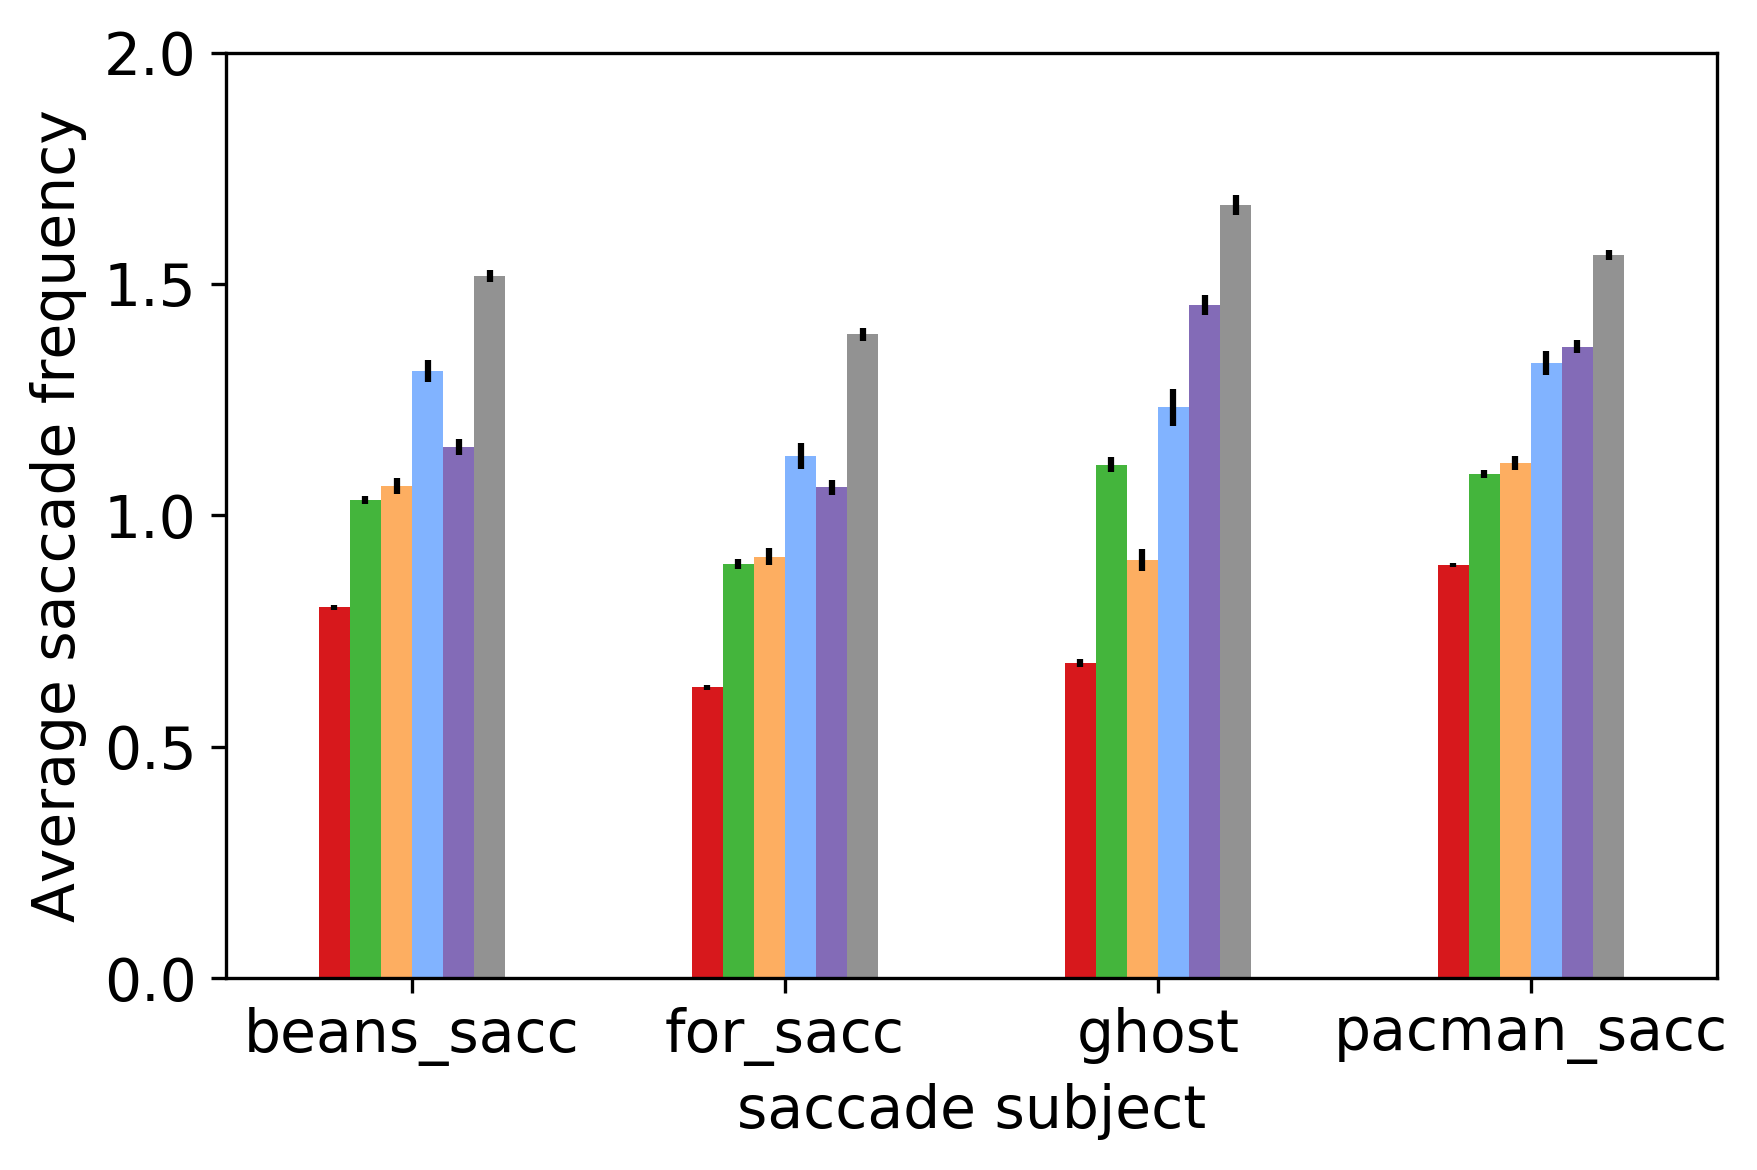

<IPython.core.display.Javascript object>

In [9]:
plot_3C_seperate(df_reset_comb, "labels", name="overall")

In [ ]:
status_order = ["vague", "approach", "local", "global", "evade", "energizer"]
sns.barplot(
    data=df_reset_comb.labels.value_counts().loc[status_order].reset_index(),
    x="index",
    y="labels",
    palette=[status_color_mapping[c] for c in status_order],
)
# plt.savefig("../analysis_pics_" + monkey + "/hist_new.pdf")

In [ ]:
plot_3C(df_reset_comb, "labels", name="overall")

### 9

In [ ]:
def z_score(df, col):
    df[col + "_z"] = (df[col] - df[col].mean()) / df[col].std()
    return df


def plot_pupil_size(df_total, col):
    state_list = ["local", "global", "evade", "energizer", "approach", "vague"]
    pupil_all = []
    df_total = (
        df_total[df_total.eye_size != 0]
        .groupby("file")
        .apply(lambda x: z_score(x, "eye_size"))
    )
    for state in state_list:
        tmp = df_total[
            (df_total.labels == state)
            & (~df_total.contribution.isnull())
            & (df_total.eye_size != 0)
        ]["eye_size_z"].values
        pupil_all.append([state, np.mean(tmp), np.std(tmp) / np.sqrt(len(tmp))])
    df_plot = (
        pd.DataFrame(pupil_all, columns=["status", "mean", "std"])
        .set_index("status")
        .loc[state_list, :]
        .reset_index()
    )
    plt.bar(
        df_plot.status,
        df_plot["mean"],
        yerr=df_plot["std"],
        color=[status_color_mapping[c] for c in df_plot.status],
    )
    #     plt.ylim(0, 3)
    plt.ylabel("Average pupil size")
    plt.xlabel("state")
    plt.legend(title=None, ncol=3)
    plt.savefig("../analysis_pics_" + monkey + "/avg_pupil_size_z.pdf")

In [ ]:
plot_pupil_size(df_reset_comb, "labels")

### 10

In [ ]:
outside = [
    (2, 5),
    (2, 24),
    (2, 12),
    (2, 33),
    (2, 9),
    (2, 30),
    (27, 5),
    (27, 24),
    (27, 12),
    (27, 33),
    (27, 9),
    (27, 30),
    (7, 24),
    (7, 18),
    (7, 9),
    (22, 24),
    (22, 18),
    (22, 9),
]
four_points = [(2, 9), (2, 30), (27, 9), (27, 30)]
sns.set_palette(plt.cm.Set2.colors[:6])
remove_tunnel = list(set(outside) - set([(7, 18), (22, 18)]))

change = [
    #     (2, 5),
    #     (2, 24),
    #     (2, 12),
    #     (2, 33),
    (2, 9),
    (2, 30),
    #     (27, 5),
    #     (27, 24),
    #     (27, 12),
    #     (27, 33),
    (27, 9),
    (27, 30),
    #     (13, 5),
    #     (16, 5),
    (7, 5),
    (22, 5),
    #     (13, 33),
    #     (16, 33),
]

In [ ]:
sel_points = change
df_plot = pd.concat(
    [
        df_reset_comb[df_reset_comb.pacmanPos.isin(sel_points)]
        .groupby("labels")
        .rt.apply(lambda x: np.mean(x / 60))
        .rename("mean"),
        df_reset_comb[df_reset_comb.pacmanPos.isin(sel_points)]
        .groupby("labels")
        .rt.apply(lambda x: np.std(x / 60) / np.sqrt(x.shape[0]))
        .rename("std"),
        df_reset_comb[df_reset_comb.pacmanPos.isin(sel_points)]
        .groupby("labels")
        .rt.count()
        .rename("size"),
    ],
    1,
).loc[["local", "global", "evade", "energizer", "approach", "vague"], :]
plt.bar(
    df_plot.index,
    df_plot["mean"],
    yerr=df_plot["std"] / np.sqrt(df_plot["size"]),
    color=[status_color_mapping[c] for c in df_plot.index],
)
plt.ylabel("seconds")
plt.tight_layout()
plt.savefig("../analysis_pics_" + monkey + "/label_rt.pdf")

### 7.4

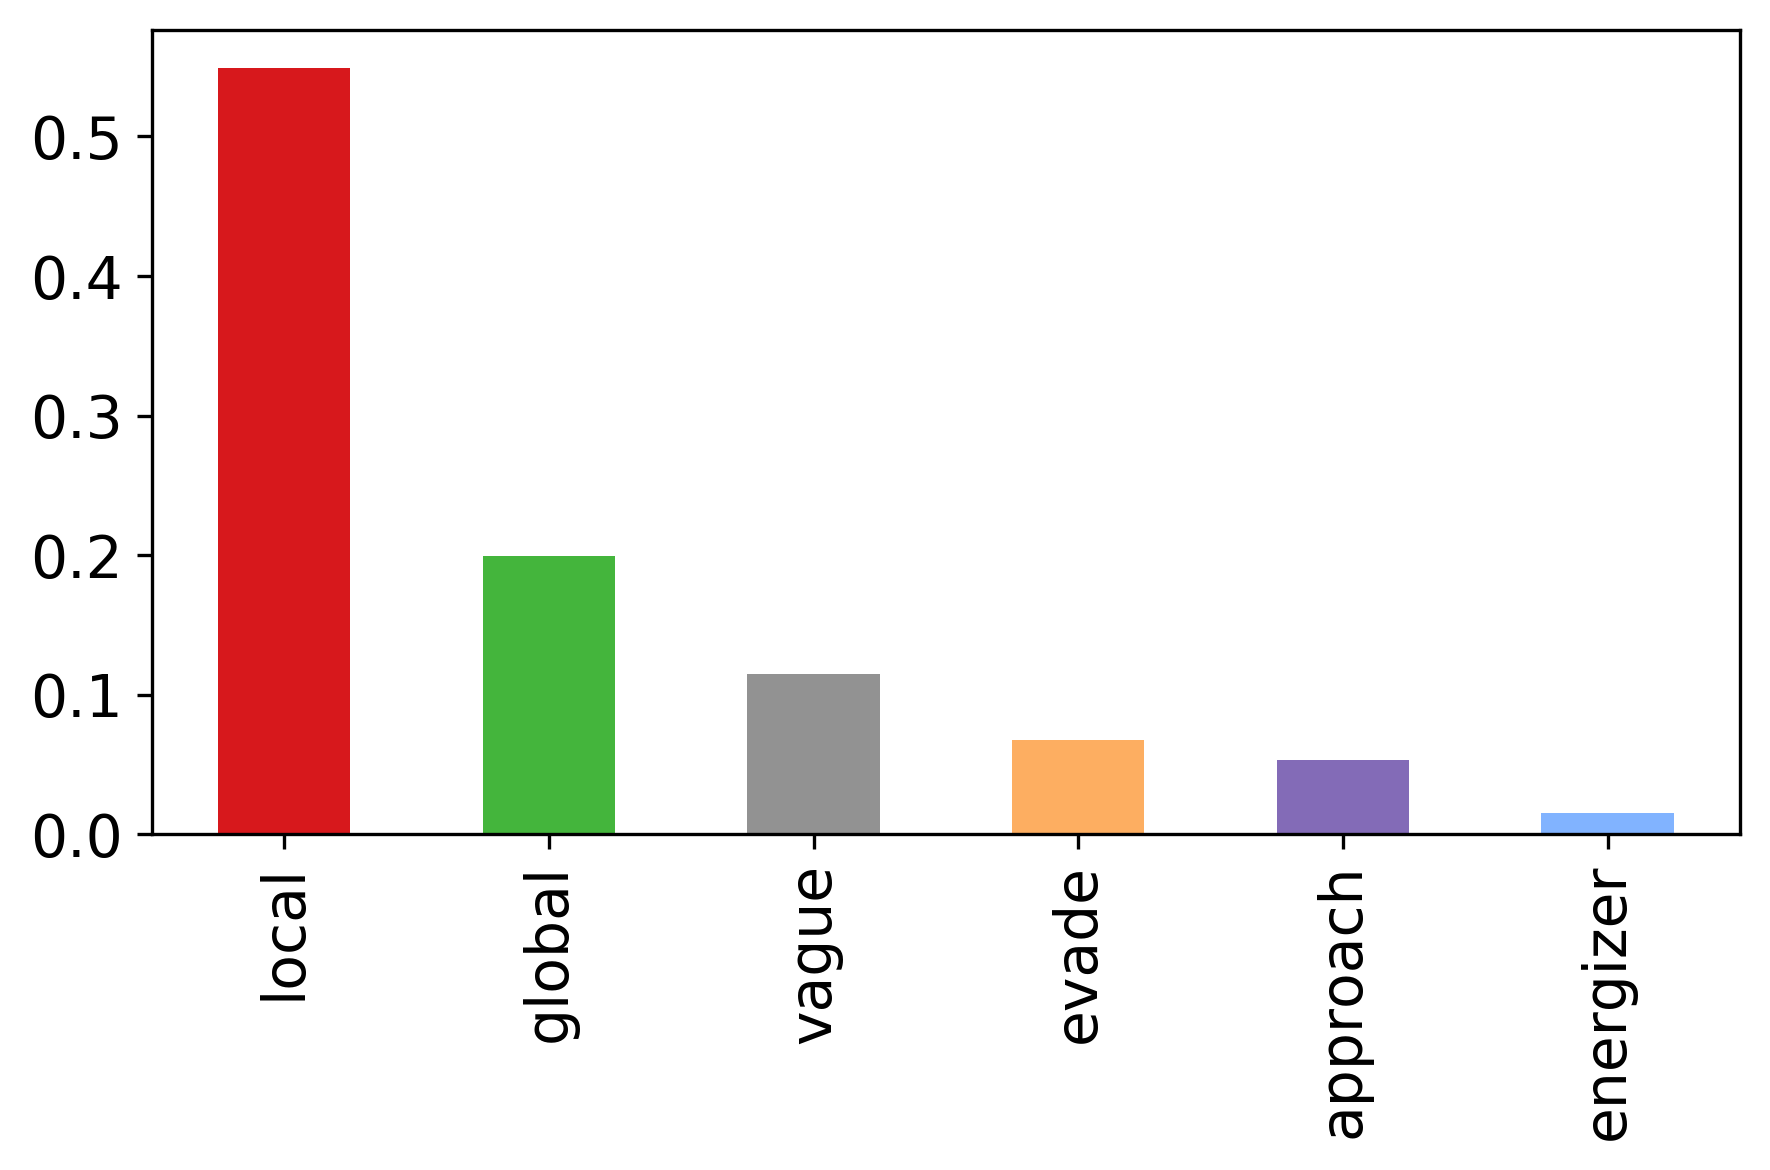

<IPython.core.display.Javascript object>

In [14]:
df_plot = df_reset_comb.labels.replace({"suicide": "approach"}).value_counts(
    normalize=True
)
df_plot.plot(kind="bar", color=[status_color_mapping[c] for c in df_plot.index])
plt.tight_layout()
plt.savefig("../analysis_pics_" + monkey + "/74.pdf")

### 7.1

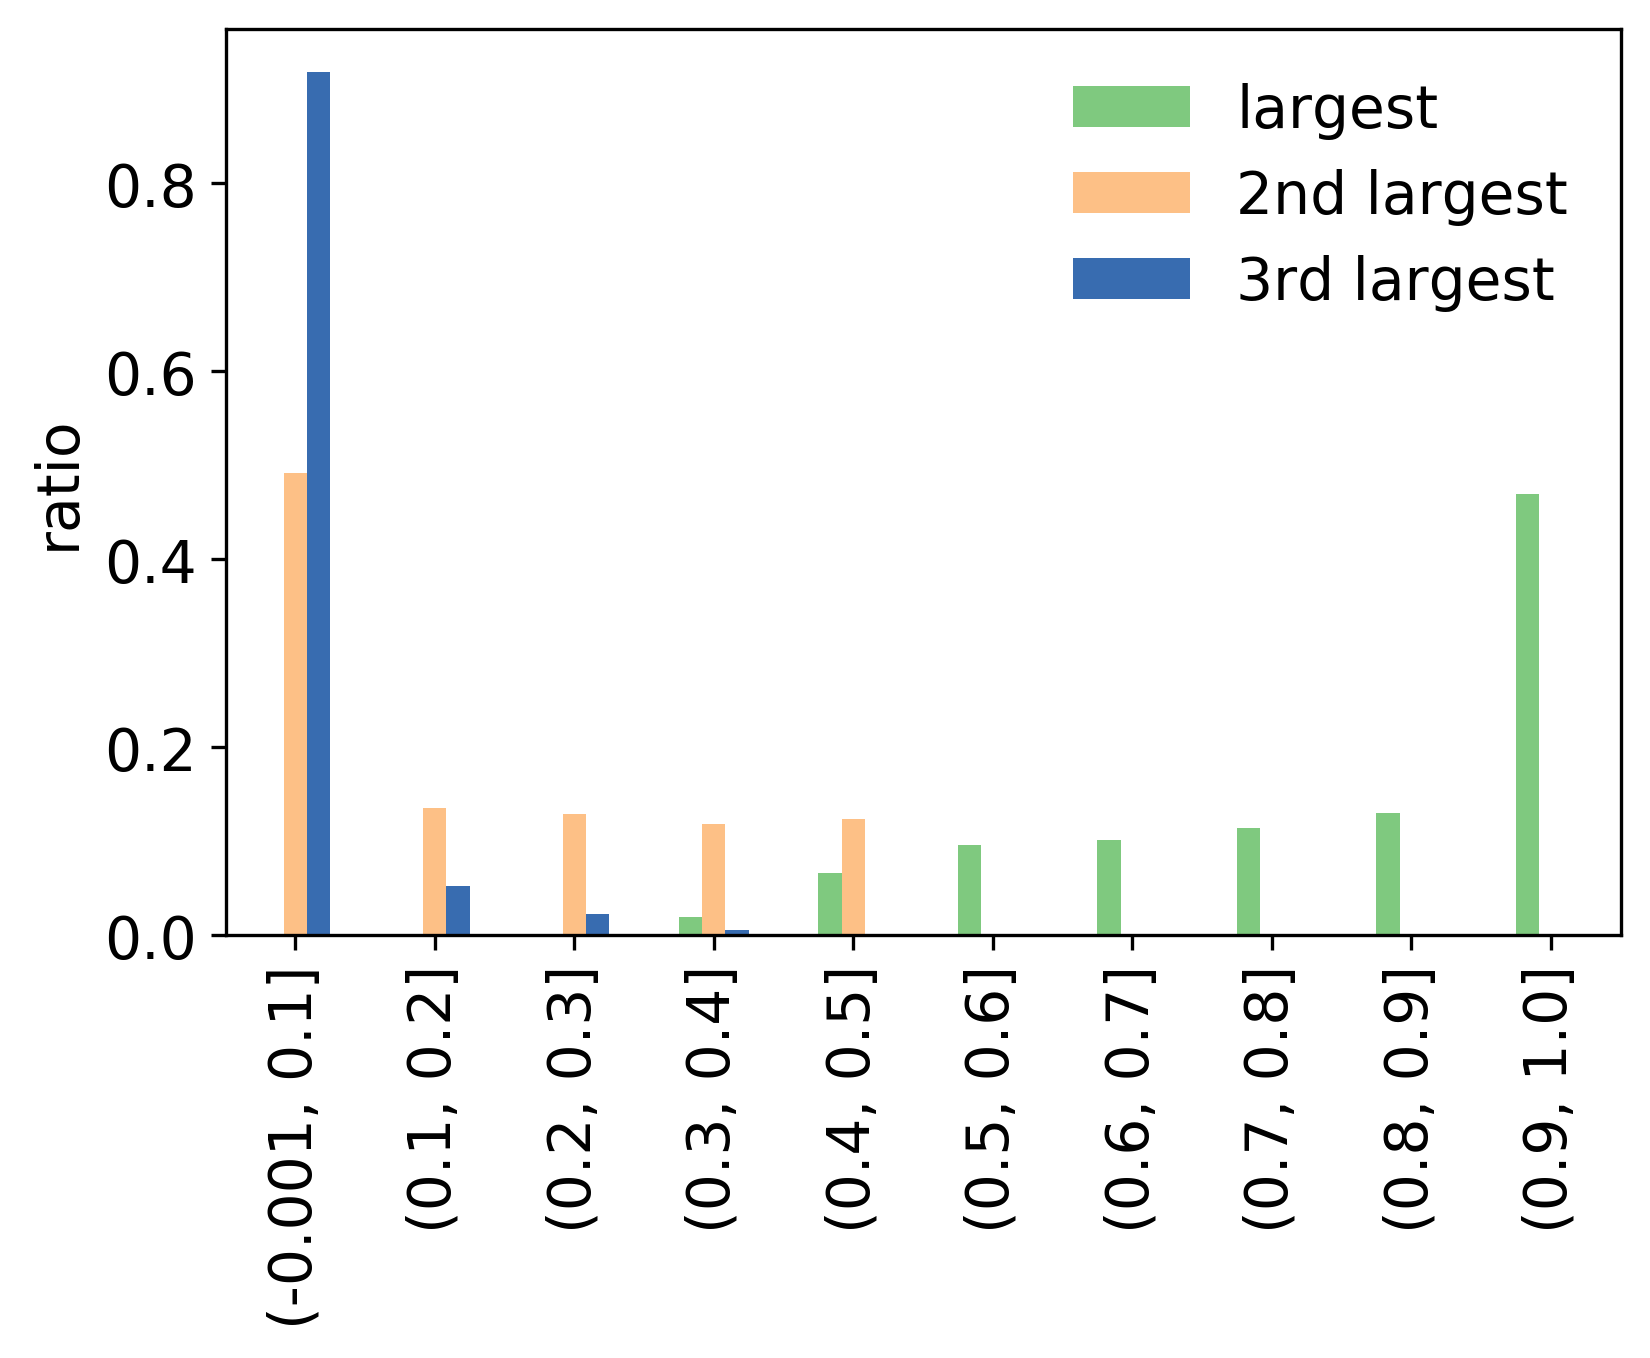

<IPython.core.display.Javascript object>

In [10]:
df_plot = pd.concat(
    [
        pd.cut(
            df_reset_comb.filter(regex="_weight").apply(
                lambda x: sorted(x.values)[-i], 1
            ),
            np.arange(0, 1.1, 0.1),
            include_lowest=True,
        )
        .value_counts()
        .sort_index()
        for i in range(1, 4)
    ],
    1,
)

df_plot = df_plot / df_plot.sum()

df_plot.columns = ["largest", "2nd largest", "3rd largest"]
df_plot.plot(kind="bar")
plt.ylabel("ratio")
plt.savefig("../analysis_pics_" + monkey + "/71.pdf")

### 7.2-7.3

In [11]:
vague_df = (
    df_reset_comb[df_reset_comb.labels == "vague"]
    .filter(regex="_weight")
    .stack()
    .sort_values(ascending=False)
    .reset_index()
    .groupby("level_0")
    .apply(
        lambda x: pd.Series(
            [i.split("_")[0] for i in x["level_1"].values[:2]],
            index=["largest", "2ndlargest"],
        )
    )
    .replace({"suicide": "approach"})
    .groupby(["largest", "2ndlargest"])
    .size()
)

<IPython.core.display.Javascript object>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


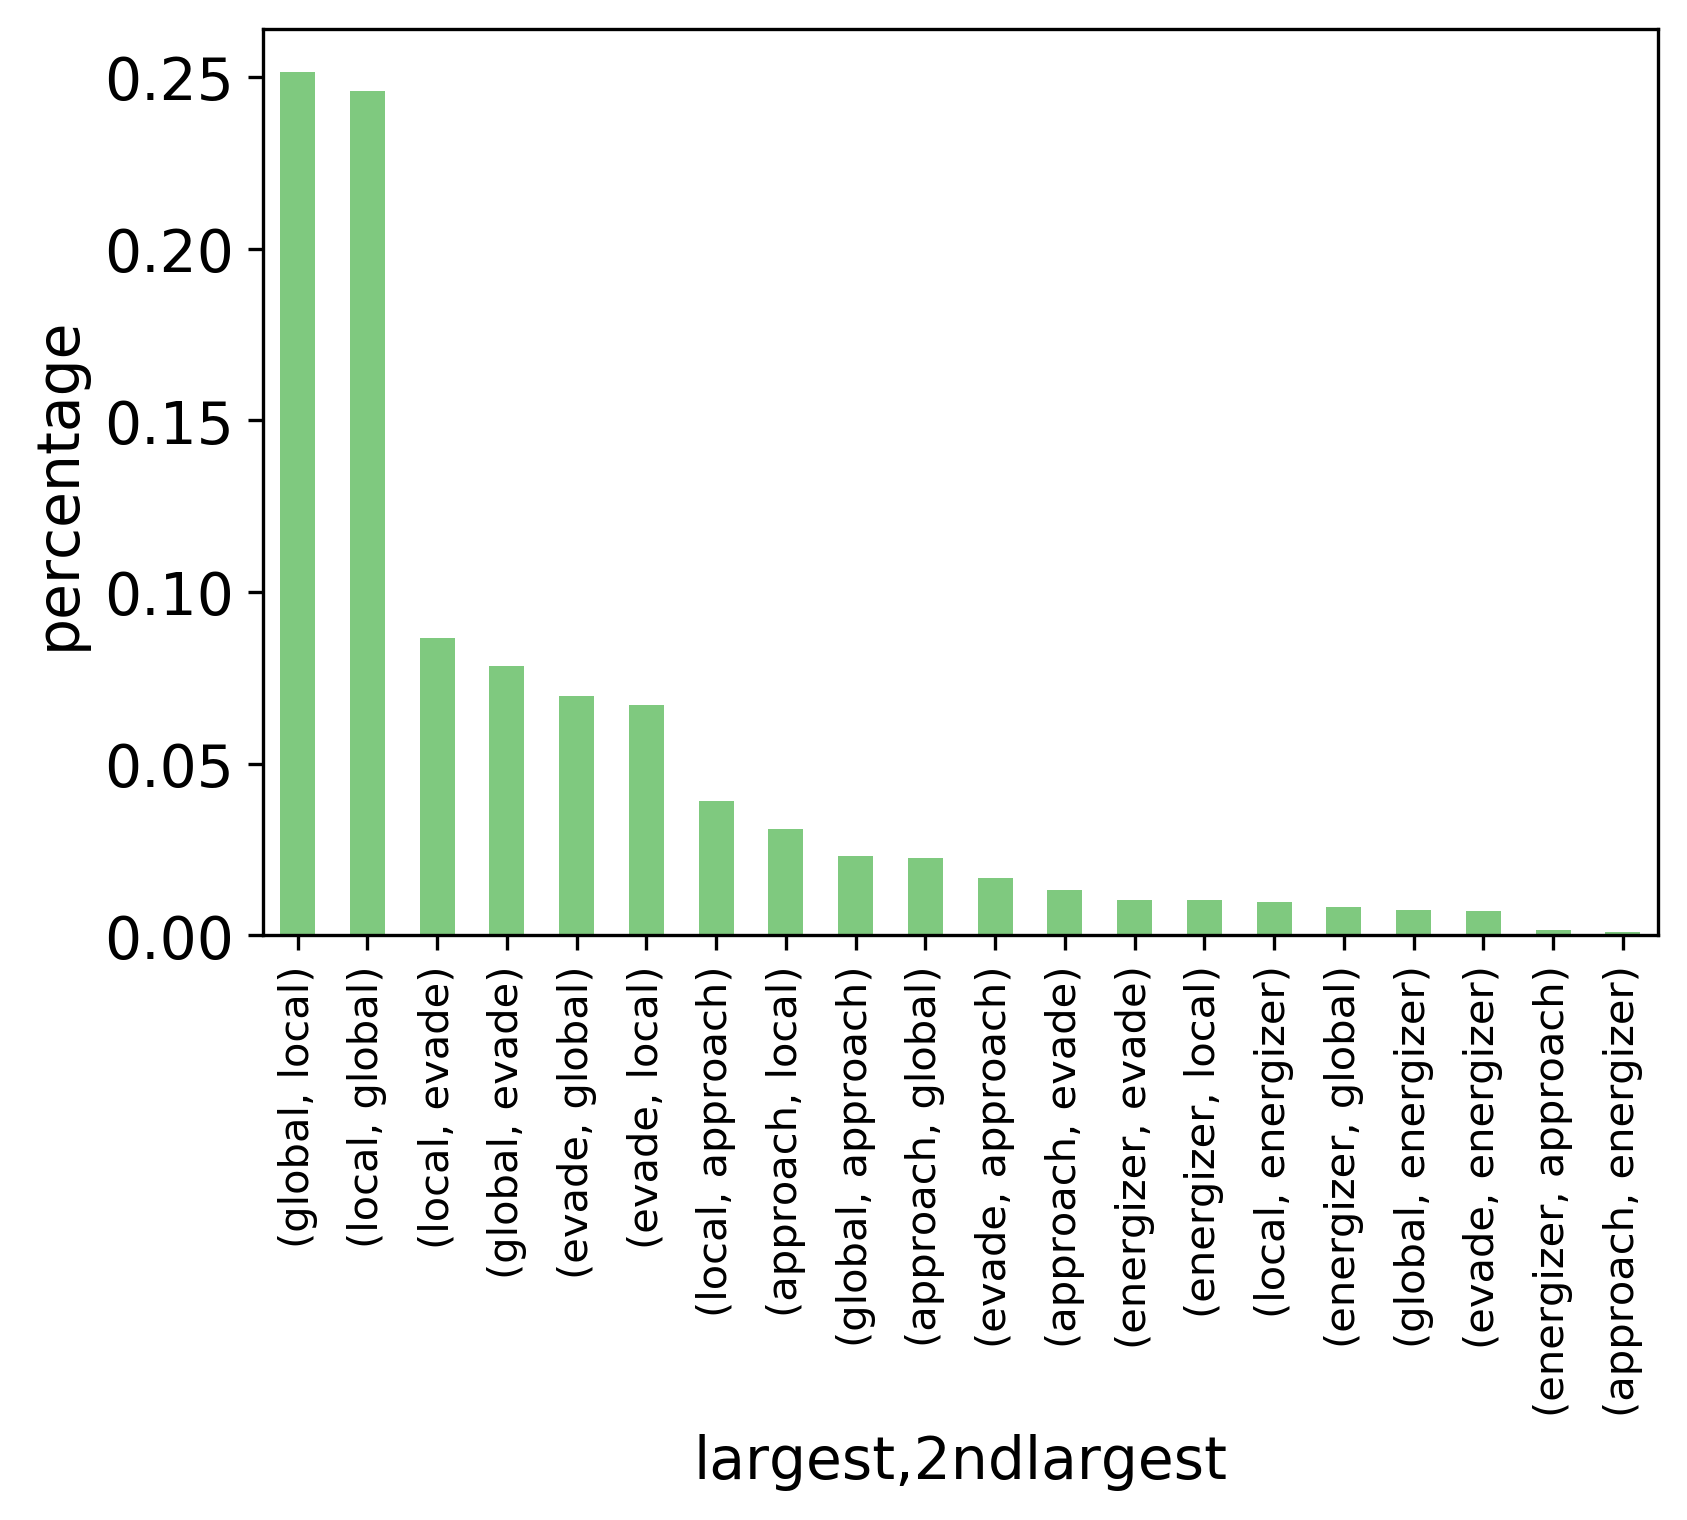

<IPython.core.display.Javascript object>

In [12]:
(vague_df / vague_df.sum()).sort_values(ascending=False).plot(kind="bar")
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("percentage")
plt.savefig("../analysis_pics_" + monkey + "/73.pdf")

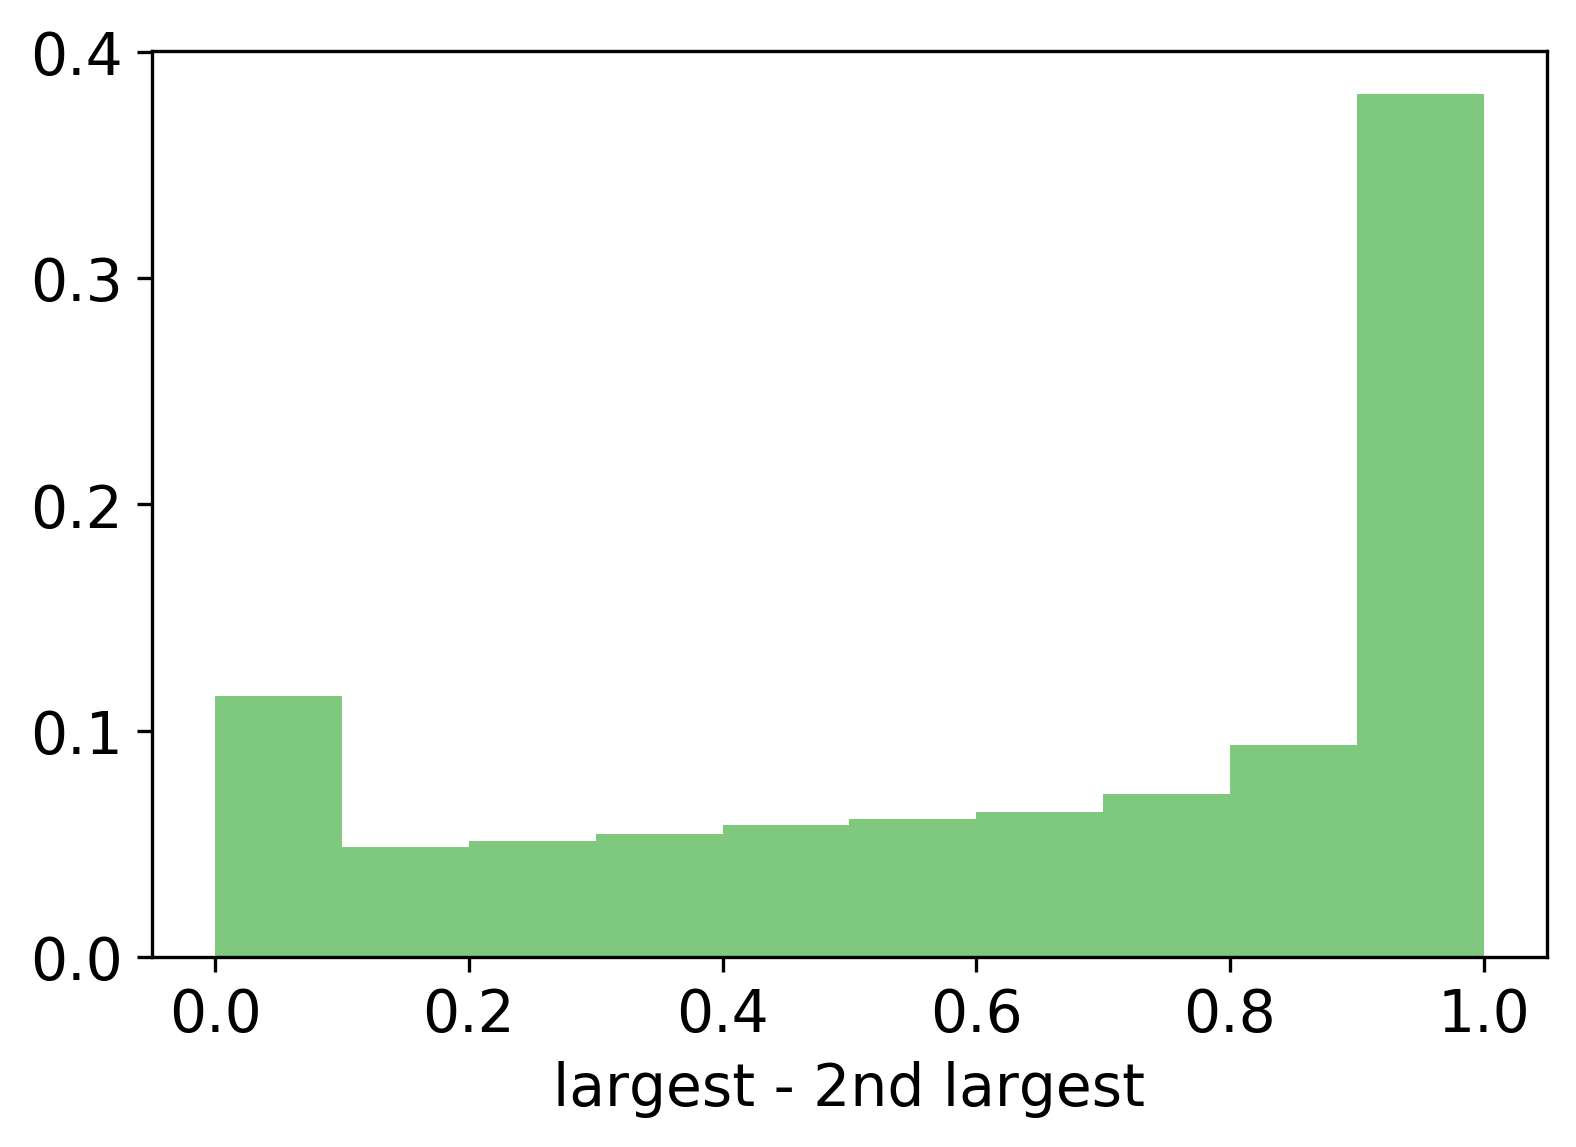

<IPython.core.display.Javascript object>

In [13]:
values = np.sort(df_reset_comb.filter(regex="_weight").dropna().values, axis=1)
pd.Series(values[:, -1] - values[:, -2]).hist(
    grid=False, weights=np.ones_like(values[:, 0]) / values.shape[0]
)
plt.xlabel("largest - 2nd largest")
plt.savefig("../analysis_pics_" + monkey + "/72.pdf")

In [ ]:
f = df.file.sample(1).values[0]
df[df.file == f]["contribution"].dropna().apply(
    lambda x: pd.Series(
        x, index=["global", "local", "pessimistic", "suicide", "energizer"],
    )
    / np.sqrt(sum(x ** 2))
).plot(figsize=(10, 3), marker="o", markersize=3)
plt.legend(ncol=5)

### 11.1A-B

In [15]:
def add_tjuntion_desired_dir(
    df_total, df_overlap, df_weights_label, landscape="fork", out_dis_thr=15
):
    if landscape == "fork":
        df_temp = pd.DataFrame(
            [
                list(i)
                for i in itertools.product(
                    POSSIBLE_DIRS.p_choice.unique(), ["up", "down", "right", "left"]
                )
            ],
            columns=["p_choice_all", "level_1_all"],
        ).merge(
            POSSIBLE_DIRS.explode("level_1"),
            how="left",
            left_on=["p_choice_all", "level_1_all"],
            right_on=["p_choice", "level_1"],
        )
        ## 选出fork从手柄进入的数据
        df_temp = (
            df_overlap[df_overlap.category == landscape]
            .merge(
                df_temp[(df_temp.p_choice.isnull())].dropna(1),
                left_on="pacmanPos",
                right_on="p_choice_all",
                how="left",
            )
            .rename(columns={"level_1_all": "t_junction_desired_dir"})
        )
        df_overlap = df_temp[df_temp.pacman_dir_fill == df_temp.t_junction_desired_dir]

    df_overlap = df_overlap[df_overlap.category == landscape]
    df_temp = (
        df_overlap[df_overlap.category == landscape][["down", "left", "right", "up"]]
        .stack()
        .reset_index()
        .merge(
            df_overlap["pacman_dir_fill"].reset_index(),
            left_on="level_0",
            right_on="index",
        )
    )
    ## 去掉进入的方向后，最大的方向和最大和第二大的豆子数的差值
    df_temp = (
        df_temp[df_temp.level_1 != df_temp.pacman_dir_fill.replace(OPPOSITE_DIRS)]
        .groupby("level_0")
        .apply(
            lambda x: pd.Series(
                [
                    -x[0].sort_values(ascending=False).diff().dropna().values[0],
                    random.sample(x[x[0] == x[0].max()].level_1.tolist(), 1),
                ],
                index=["local_4dirs_diff", "largest_dir"],
            )
        )
    )

    df_temp = pd.concat([df_overlap, df_temp], 1)

    df_temp["choose_largest"] = df_temp.apply(
        lambda x: x.next_pacman_dir_fill in x.largest_dir
        if not isinstance(x.largest_dir, float)
        else np.nan,
        1,
    )

    df_ghost = df_total[
        [
            "file",
            "index",
            "distance1",
            "distance2",
            "rwd_cnt",
            "ghost1Pos",
            "ghost2Pos",
            "ghost1_dir",
            "ghost2_dir",
        ]
    ].merge(df_weights_label, how="left", on=["file", "index"])
    df_comb = df_temp.merge(df_ghost, how="left", on=["file", "index"])
    df_plot = (
        df_comb[
            (df_comb["labels"] == "evade")
            & (
                df_comb.next_pacman_dir_fill
                != df_comb.pacman_dir_fill.replace(OPPOSITE_DIRS)
            )
        ]
        .dropna()
        .drop(columns=["if_cross", "category", "NextNum",])
    )
    return df_plot


def generate_4dir_beans(df_total, thr, rwd=False):
    df1 = (
        df_total[["beans", "pacmanPos"]]
        .explode("beans")
        .reset_index()
        .merge(
            pd.concat(
                [
                    LOCS_DF[LOCS_DF.dis == thr].pos1.rename("pacmanPos"),
                    LOCS_DF[LOCS_DF.dis == thr].path.explode(),
                    LOCS_DF[LOCS_DF.dis == thr]
                    .path.explode()
                    .apply(lambda x: relative_dir(x[1], x[0])[0])
                    .rename("relative_dir"),
                ],
                1,
            )
            .explode("path")
            .rename(columns={"path": "beans"}),
            on=["pacmanPos", "beans"],
        )
        .merge(
            pd.concat(
                [
                    df_total.energizers.explode()
                    .reset_index()
                    .assign(reward=4)
                    .rename(columns={"energizers": "beans"}),
                    df_total.fruitPos.reset_index()
                    .assign(reward=8)
                    .rename(columns={"fruitPos": "beans"}),
                ]
            ),
            how="left",
            on=["level_0", "beans"],
        )
        .fillna(2)
    )
    if not rwd:
        return (
            df1.groupby(["level_0", "relative_dir"])["reward"]
            .size()
            .unstack("relative_dir")
            .fillna(0)
        )
    else:
        return (
            df1.groupby(["level_0", "relative_dir"])["reward"]
            .sum()
            .unstack("relative_dir")
            .fillna(0)
        )


def go_to_most_beans(
    df_overlap, cate_df, save_path, only_cross_fork, exclude_2dirs, landscape
):
    pp = []
    for n in [5]:
        if only_cross_fork:
            """这个仅仅适合n=5的情况"""
            extend_cross_fork(df_overlap, save_path)
            break
        if exclude_2dirs:
            df_overlap = exclude_2dirs(df_overlap)

        """1)是否选择了最大的方向choice_large 2) 这个位置是不是转弯口"""
        df_overlap = df_overlap.assign(
            choice_large=df_overlap.next_pacman_dir_fill == df_overlap.largest_dir,
            if_cross=df_overlap.pacmanPos.isin(TURNING_POS),
        )

        """准备画图元素"""
        """如果需要按照地形来分的话，需要把comment掉的东西都恢复"""
        result_df = (
            df_overlap[df_overlap[["down", "up", "left", "right"]].max(1) > 0]
            .groupby(
                [
                    "NextNum",
                    "if_cross",
                    df_overlap[
                        df_overlap[["down", "up", "left", "right"]].max(1) > 0
                    ].local_4dirs_diff.apply(lambda x: min(x, 4)),
                ]
            )
            .choice_large.apply(
                lambda x: pd.Series({"mean": x.mean(), "count": len(x), "std": x.std()})
            )
            .unstack()
            .reset_index()
        ).merge(cate_df, on=["if_cross", "NextNum"], how="left",)
        #     result_df = result_df[result_df.category.isin(["fork", "cross"])]
        if landscape:
            plt.figure(dpi=300)
            ax = sns.scatterplot(
                data=result_df,
                x="local_4dirs_diff",
                y="mean",
                #             size=result_df["count"],
                #                 ax=ax,
                hue="category",
                hue_order=["straight", "L-shape", "fork", "cross"],
                sizes=(20, 200),
            )
            for c in ["straight", "L-shape", "fork", "cross"]:
                gpd = result_df[result_df.category == c]
                ax.errorbar(
                    gpd["local_4dirs_diff"],
                    gpd["mean"],
                    yerr=gpd["std"] / np.sqrt(gpd["count"]),
                    marker=None,
                    capsize=3,
                )
            ax.legend()
            ax.set_xticks([0, 1, 2, 3, 4])
            ax.set_xticklabels([0, 1, 2, 3, ">=4"])
            ax.set_xlabel("local reward max - 2nd max")
            ax.set_ylabel("% of toward the most valuable direction")
            ax.set_title("errorbar = traditional std")
            ax.set_ylim(0, 1)
            ax.figure.savefig(save_path)
        else:
            errorplot = ax.errorbar(
                result_df[result_df.category == land]["local_4dirs_diff"],
                result_df[result_df.category == land]["mean"],
                #         yerr=result_df["std"] / np.sqrt(result_df["count"]),
                marker="o",
                #         capsize=3,
            )
            pp.append(errorplot.lines[0])

            # use them in the legend
            ax.legend(pp, [str(i) for i in [1, 3, 5, 7]], ncol=4, numpoints=1)
            ax.set_xticks([0, 1, 2, 3, 4])
            ax.set_xticklabels([0, 1, 2, 3, ">=4"])
            plt.xlabel("local reward max - 2nd max")
            plt.ylabel("% of toward the most valuable direction")
            plt.title(land.capitalize() + " Local Graze")
            plt.savefig(save_path)

<IPython.core.display.Javascript object>

In [20]:
df_reset_comb.index.name = "level_0"
df_overlap = generate_4dir_beans(df_reset_comb, 5, rwd=False)
# df_overlap_inner = generate_4dir_beans(df_reset_comb, 10, rwd=False)
# df_overlap = df_overlap - df_overlap_inner.reindex(df_overlap.index).fillna(0)

df_overlap.columns.name = None
df_overlap.index.name = None

df_reset_comb.index.name = None

df_overlap = df_overlap.assign(
    largest_dir=df_overlap.eq(df_overlap.max(1), axis=0)
    .stack()
    .replace({False: np.nan})
    .dropna()
    .reset_index()
    .groupby("level_0")
    .apply(lambda x: random.choice(x.level_1.values)),
    local_4dirs_diff=largest_2ndlargest_diff(df_overlap),
)

<IPython.core.display.Javascript object>

In [21]:
cate_df = pd.DataFrame(
    [
        [2, False, "straight"],
        [2, True, "L-shape"],
        [3, True, "fork"],
        [4, True, "cross"],
    ],
    columns=["NextNum", "if_cross", "category"],
)

df_overlap = (
    pd.concat(
        [
            df_reset_comb[
                [
                    "file",
                    "index",
                    "next_pacman_dir_fill",
                    "pacmanPos",
                    "pacman_dir_fill",
                    "labels",
                ]
            ],
            df_overlap,
        ],
        1,
    )
    .fillna(0)
    .merge(
        MAP_INFO[["pos", "NextNum"]], left_on="pacmanPos", right_on="pos", how="left"
    )
    .drop(columns=["pos"])
    .sort_values(by=["file", "index"])
)
df_overlap["if_cross"] = df_overlap.pacmanPos.isin(TURNING_POS)
df_overlap = df_overlap.merge(
    cate_df, how="left", on=["if_cross", "NextNum"]
).sort_values(by=["file", "index"])

<IPython.core.display.Javascript object>

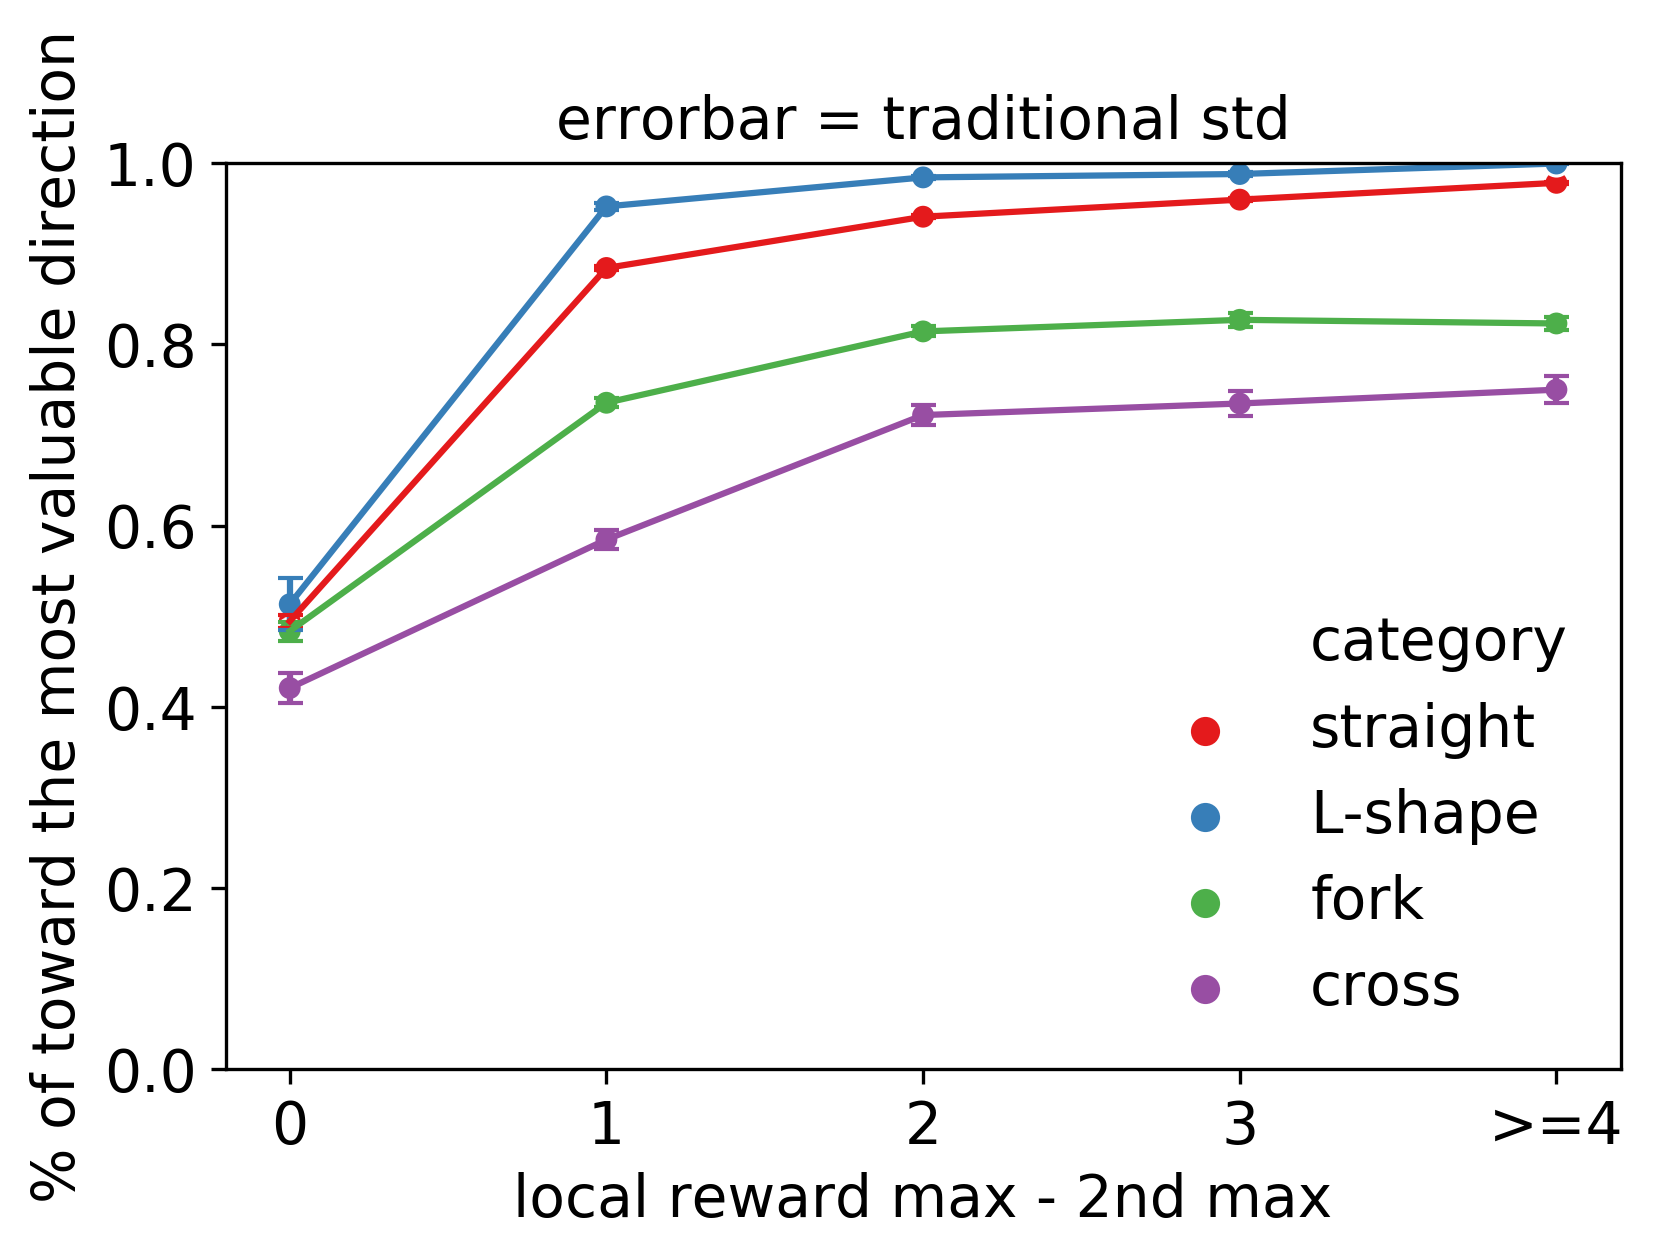

<IPython.core.display.Javascript object>

In [23]:
sns.set_palette(plt.cm.Set1.colors[:4])
go_to_most_beans(
    df_overlap[df_overlap.labels == "local"],
    cate_df,
    "../analysis_pics_" + monkey + "/psychomatric_curve_local.pdf",
    only_cross_fork=False,
    exclude_2dirs=False,
    landscape=True,
)

### 11.1C

In [24]:
def how_many_turns(df, start, end):
    dirs = df.loc[start:end, "pacman_dir_fill"]
    return ((dirs != dirs.shift()) & (dirs != dirs.replace(OPPOSITE_DIRS))).sum() - 1


def how_many_turns_poss(poss):
    dirs = [
        relative_dir(poss[i + 1], poss[i])[0] if poss[i + 1] != poss[i] else np.nan
        for i in range(len(poss) - 1)
    ]
    dirs = pd.Series(dirs).fillna(method="ffill")
    return ((dirs != dirs.shift()) & (dirs != dirs.replace(OPPOSITE_DIRS))).sum() - 1

<IPython.core.display.Javascript object>

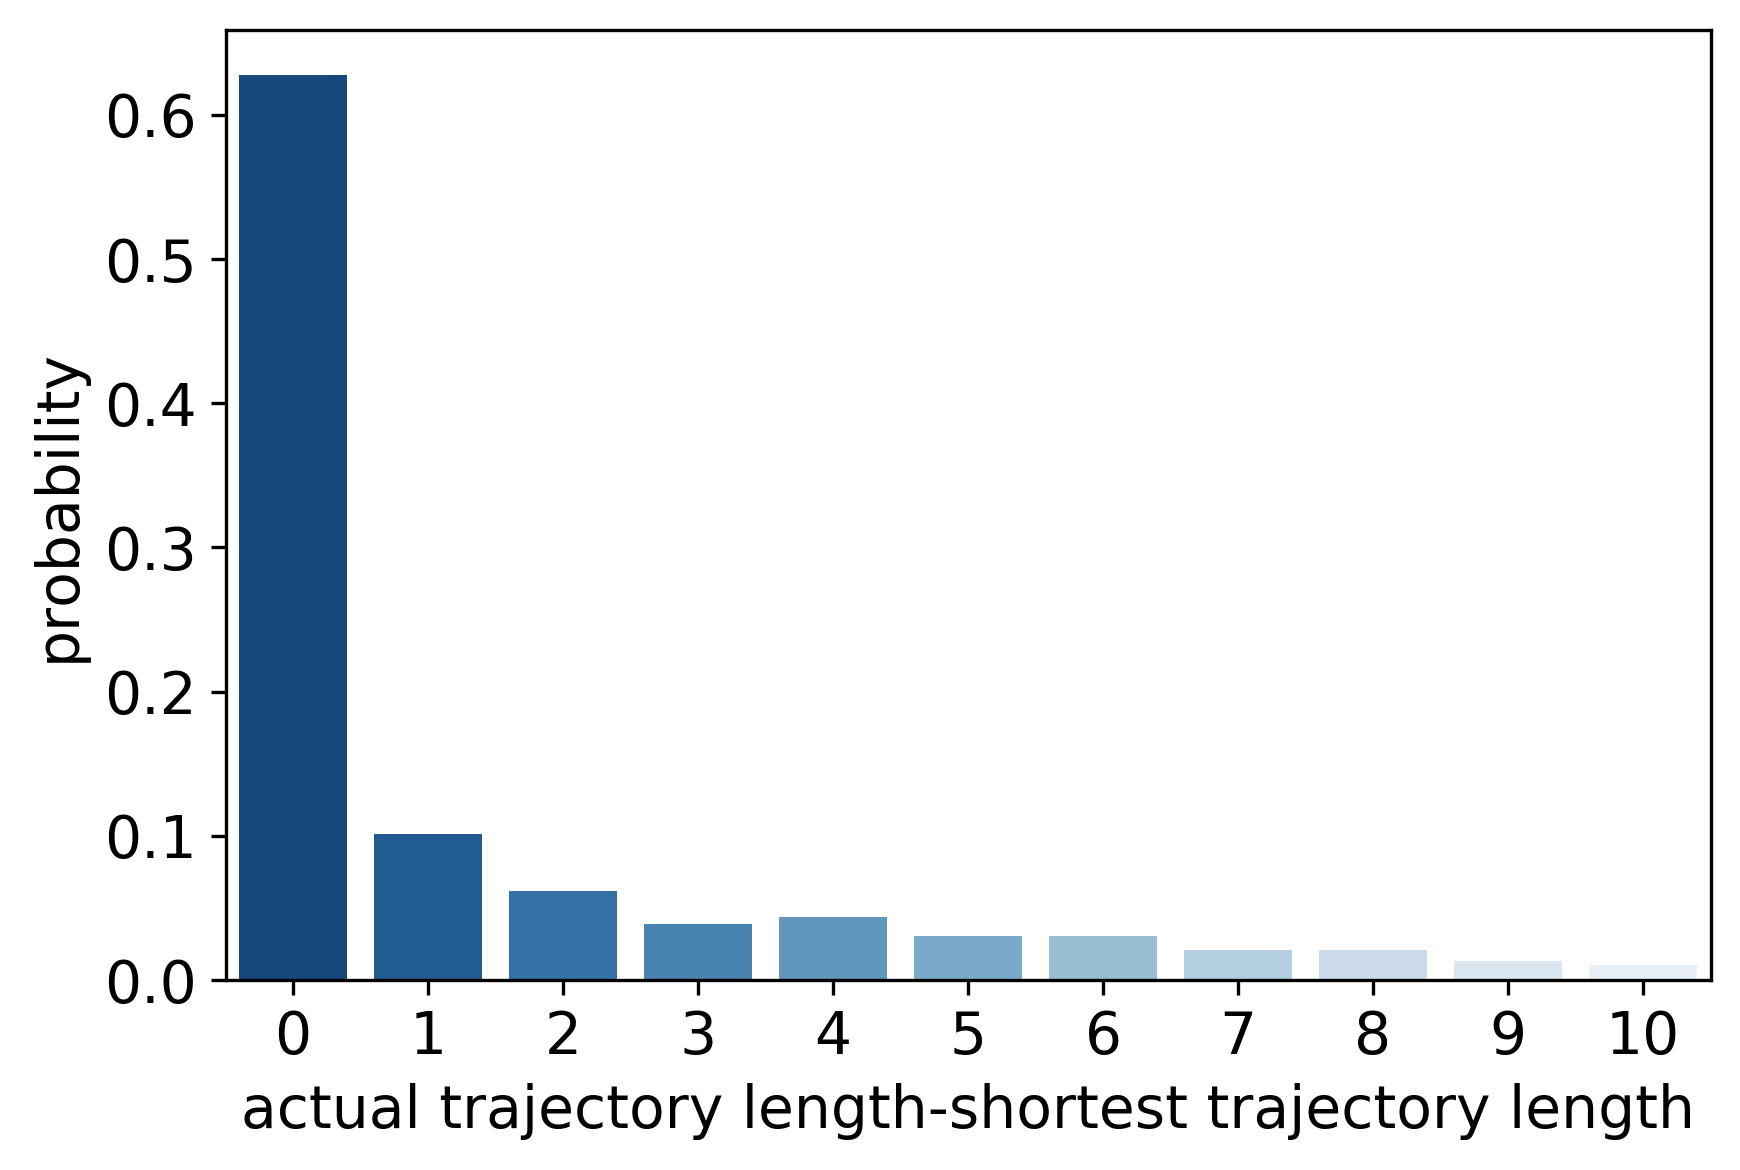

<IPython.core.display.Javascript object>

In [25]:
global_lists = [
    list(i)
    for i in consecutive_groups(df_reset_comb[df_reset_comb.labels == "global"].index)
]

global_lists = list(filter(lambda x: len(x) >= 4, global_lists))

df_temp = df_reset_comb.loc[
    [i[0] for i in global_lists], ["file", "rwd_cnt"]
].drop_duplicates(keep="first")
df_temp["rwd_cnt"] = df_temp["rwd_cnt"] - 1
df_temp["end_index"] = df_temp.merge(
    df_reset_comb[["file", "rwd_cnt"]].drop_duplicates(keep="first").reset_index(),
    on=["file", "rwd_cnt"],
    how="left",
)["index"].values

start_end_index = (
    df_temp.reset_index()[["index", "end_index"]]
    .dropna()
    .astype(int)
    .rename(columns={"index": "start_index"})
)

actual_routes = (
    df_reset_comb["pacmanPos"]
    .reset_index()
    .merge(
        df_reset_comb["pacmanPos"]
        .reset_index()
        .merge(start_end_index, left_on="index", right_on="start_index"),
        left_on="index",
        right_on="end_index",
        suffixes=["_end", "_start"],
    )
    .drop(columns=["index_end", "index_start"])
)
actual_routes["actual_length"] = actual_routes.end_index - actual_routes.start_index
actual_routes = add_dis(actual_routes, "pacmanPos_start", "pacmanPos_end")

ylim = 10
data = (
    (actual_routes.actual_length - actual_routes.dis)
    .where(lambda x: x <= ylim)
    .value_counts()
    .sort_index()
    .reset_index()
)

ax = sns.barplot(data=data, x="index", y=data[0] / data[0].sum(), palette="Blues_r",)
ax.set_xticks(range(ylim + 1))
ax.set_xticklabels(range(ylim + 1))
ax.set_xlabel("actual trajectory length-shortest trajectory length")
ax.set_ylabel("probability")
plt.tight_layout()
plt.savefig("../analysis_pics_" + monkey + "/111c1.pdf")

In [26]:
actual_routes["actual_turns"] = actual_routes.apply(
    lambda x: how_many_turns(df_reset_comb, x["start_index"], x["end_index"]), 1
)

actual_routes = actual_routes.merge(
    LOCS_DF[["pos1", "pos2", "path"]],
    left_on=["pacmanPos_end", "pacmanPos_start"],
    right_on=["pos1", "pos2"],
)

actual_routes["fewest_turns"] = actual_routes.apply(
    lambda x: min([how_many_turns_poss(i) for i in x.path]), 1
)

<IPython.core.display.Javascript object>

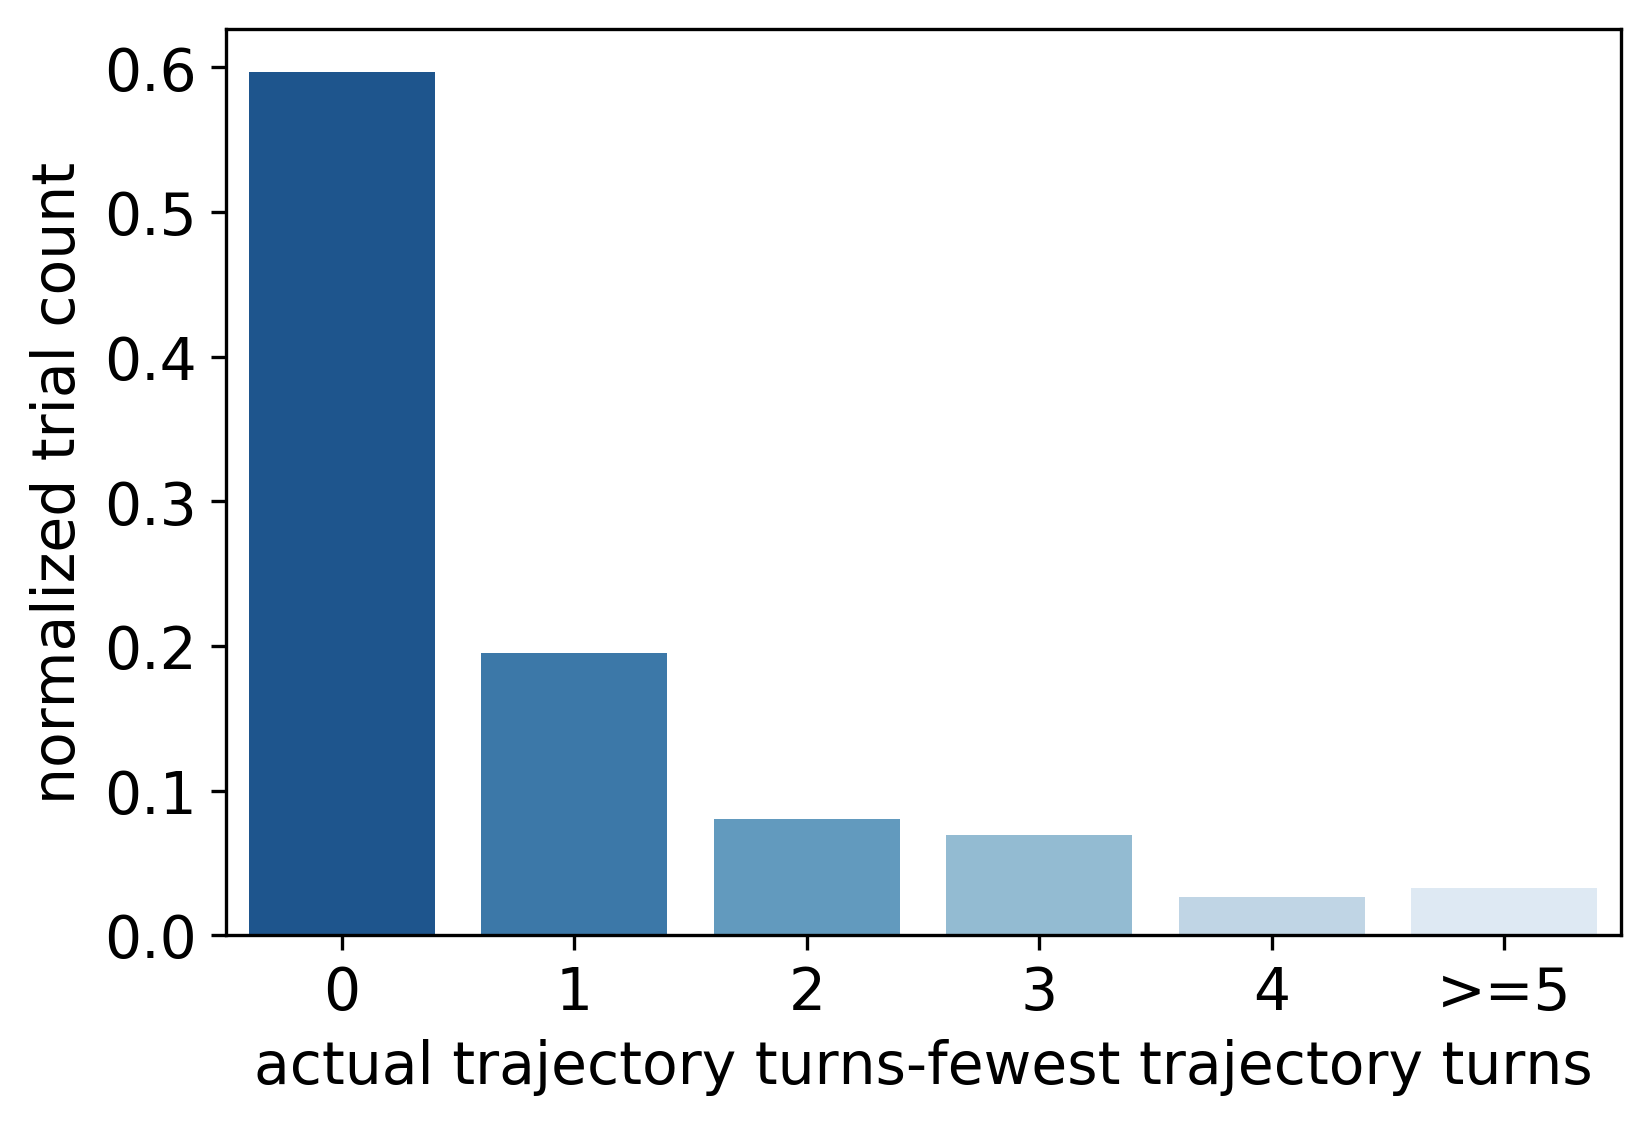

<IPython.core.display.Javascript object>

In [27]:
data = (
    (actual_routes.actual_turns - actual_routes.fewest_turns)
    .where(lambda x: x >= 0)
    .dropna()
    .apply(lambda x: int(min(x, 5)))
    .value_counts()
    .sort_index()
    .reset_index()
)
ax = sns.barplot(data=data, x="index", y=data[0] / data[0].sum(), palette="Blues_r")
ax.set_xticks(range(6))
ax.set_xticklabels(list(range(5)) + [">=5"])
ax.set_xlabel("actual trajectory turns-fewest trajectory turns")
ax.set_ylabel("normalized trial count")
plt.savefig("../analysis_pics_" + monkey + "/111c2.pdf")

### 11.2A

In [28]:
energizer_start_index = df_reset_comb[
    (df_reset_comb.eat_energizer == True)
    & (df_reset_comb[["ifscared1", "ifscared2"]].min(1).shift() < 3)
][["next_eat_rwd", "energizers", "ifscared1", "ifscared2"]].index

energizer_lists = [
    np.arange(
        i,
        (df_reset_comb.loc[i:, ["ifscared1", "ifscared2"]] <= 3)
        .max(1)
        .where(lambda x: x == True)
        .dropna()
        .index[0],
    )
    for i in energizer_start_index
]

<IPython.core.display.Javascript object>

In [29]:
approach_index = list(
    itertools.chain.from_iterable(
        [
            i[5:]
            for i in energizer_lists
            if (df_reset_comb.loc[i[:5], "labels"] == "approach").sum() > 0
        ]
    )
)
local_index = list(
    itertools.chain.from_iterable(
        [
            i[5:]
            for i in energizer_lists
            if (df_reset_comb.loc[i[:5], "labels"] == "approach").sum() == 0
        ]
    )
)

<IPython.core.display.Javascript object>

In [ ]:
bincut = 2
dict_temp = {"local": local_index, "approach": approach_index}
for key, item in dict_temp.items():
    df = df_reset_comb.assign(
        comb_dis=df_reset_comb[["distance1", "distance2"]].min(1)
    ).loc[dict_temp[key], :]
    for weight in ["approach_weight", "local_weight"]:
        df_plot = df.pivot_table(
            columns=np.ceil(df["rwd_pac_distance"] / bincut) * bincut,
            index=np.ceil(df["comb_dis"] / bincut) * bincut,
            values=weight,
            aggfunc=lambda x: x.mean() if len(x) > 3 else np.nan,
        )

        plt.figure(figsize=(8, 8))
        ax = sns.heatmap(
            df_plot.reindex(range(0, 20, bincut)).T.reindex(range(0, 30, bincut)).T,
            square=True,
            cmap="coolwarm_r",
            vmin=0,
            vmax=0.8,
            cbar_kws={"shrink": 0.5},
        )
        ax.invert_yaxis()
        ax.set_xticklabels(
            [i.get_text().split(".")[0] for i in ax.get_xticklabels()], rotation=0
        )
        ax.set_yticklabels([i.get_text().split(".")[0] for i in ax.get_yticklabels()])
        ax.set_ylabel("P-G Distance")
        ax.set_xlabel("P-Nearest B Distance")
        plt.title(key + "_trial_" + weight)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels([0, 1])
        b, t = plt.ylim()  # discover the values for bottom and top
        plt.ylim(b - 0.5, t + 0.5)  # update the ylim(bottom, top) values
    #     plt.savefig("../analysis_pics_" + monkey + "/112a_" + key + ".pdf")

### 11.2B

In [30]:
def add_PEG_dis(df_total):
    diss = add_dis(
        add_dis(
            add_dis(
                df_total[
                    ["ghost2Pos", "ghost1Pos", "next_eat_energizer", "pacmanPos"]
                ].reset_index(),
                "pacmanPos",
                "next_eat_energizer",
                "PE_dis",
            ),
            "next_eat_energizer",
            "ghost1Pos",
            "EG1_dis",
        ),
        "next_eat_energizer",
        "ghost2Pos",
        "EG2_dis",
    )

    diss["EG_dis"] = diss[["EG1_dis", "EG2_dis"]].min(1)
    df_total = pd.concat(
        [
            df_total,
            diss.set_index("index")[["PE_dis", "EG_dis", "EG1_dis", "EG2_dis"]],
        ],
        1,
    )
    return df_total

<IPython.core.display.Javascript object>

In [31]:
# 找到在每个sub trial之前，开始径直去吃energizer的index
df_temp = (
    pd.Series(energizer_lists)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
    .dropna()
    .reset_index()
    .astype(int)
    .set_index(0)
    .reindex(range(417238))
    .rename(columns={"index": "last_index"})
)

df_temp.loc[~df_temp.last_index.isnull(), "last_index"] = df_temp.loc[
    ~df_temp.last_index.isnull()
].index

df_temp = df_temp.fillna(method="bfill")

pre_index = (
    add_dis(
        df_temp.reset_index()
        .rename(columns={0: "prev_index"})
        .merge(
            df_reset_comb["pacmanPos"].reset_index(),
            left_on="prev_index",
            right_on="index",
            how="left",
        )
        .drop(columns="index")
        .merge(
            df_reset_comb["pacmanPos"].reset_index(),
            left_on="last_index",
            right_on="index",
            how="left",
            suffixes=["_prev", "_last"],
        ),
        "pacmanPos_prev",
        "pacmanPos_last",
    )
    .sort_values(by="prev_index")
    .groupby("index")
    .apply(
        lambda x: x.set_index("prev_index")
        .dis.diff()
        .where(lambda x: x > 0)
        .dropna()
        .index.values[-1]
        if len(x.dis.diff().where(lambda x: x > 0).dropna()) > 0
        else x.prev_index.values[0]
    )
)

<IPython.core.display.Javascript object>

In [32]:
cons_list_plan = [
    np.arange(pre_index[i[0]], i[0])
    for i in energizer_lists
    if (df_reset_comb.loc[i[:5], "labels"] == "approach").sum() > 0 and len(i) > 0
]

cons_list_accident = [
    np.arange(pre_index[i[0]], i[0])
    for i in energizer_lists
    if (df_reset_comb.loc[i[:5], "labels"] == "approach").sum() == 0 and len(i) > 0
]

<IPython.core.display.Javascript object>

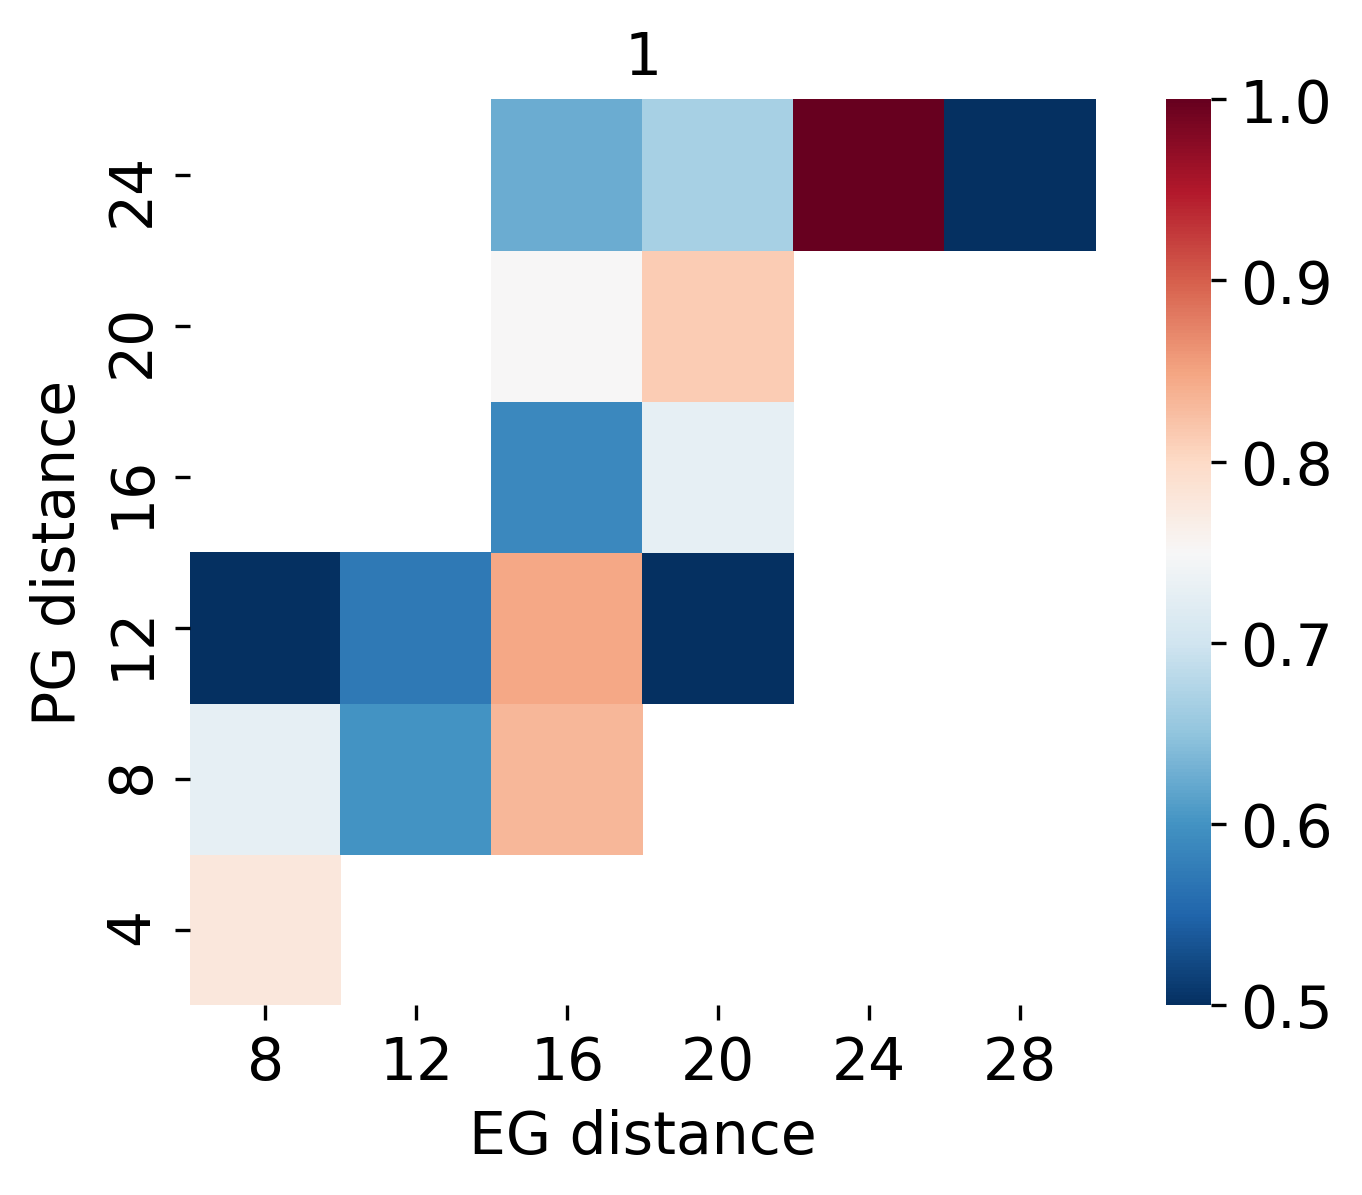

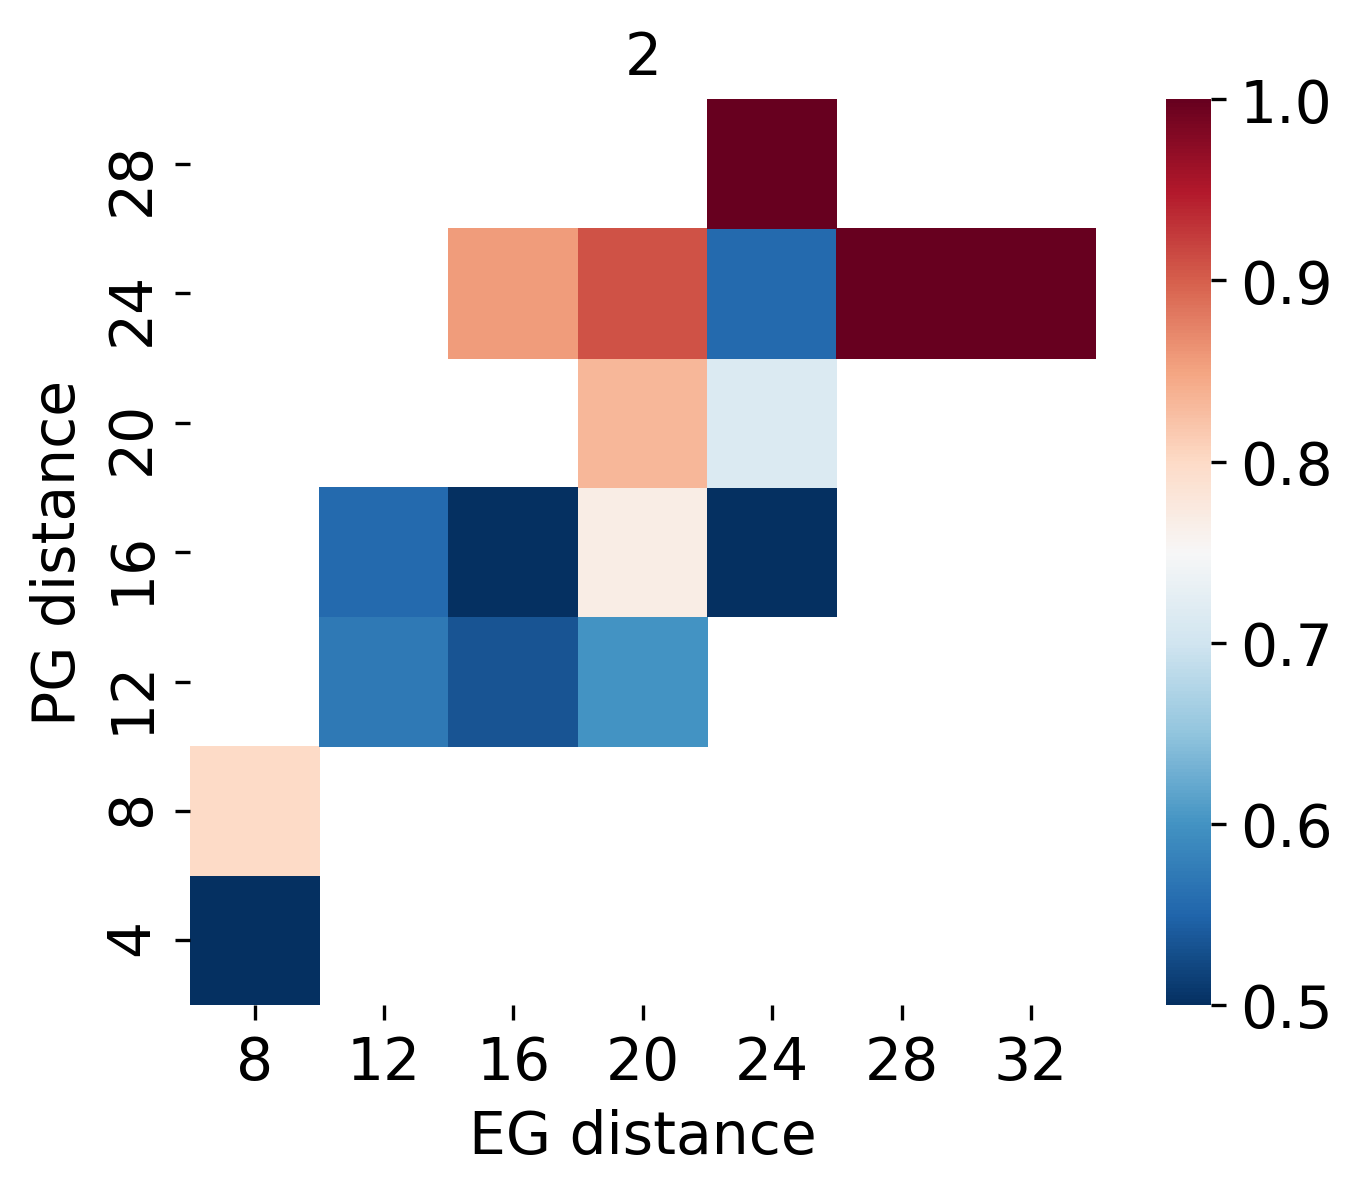

<IPython.core.display.Javascript object>

In [33]:
df_reset_comb_extend = add_PEG_dis(
    df_reset_comb.drop(columns=["PE_dis", "EG1_dis", "EG2_dis"])
)
mapping = {1: "Accidentally Hunting", 2: "Planned Hunting"}
sns.set_palette(plt.cm.Set1.colors[:2])
bin_size = 4
for ghost in ["1", "2"]:
    i = 1
    df_status = pd.DataFrame()
    for sel_list in [cons_list_accident, cons_list_plan]:
        sel_list = pd.Series(sel_list)[
            pd.Series(sel_list)
            .explode()
            .reset_index()
            .set_index(0)
            .reset_index()
            .merge(df_reset_comb_extend.reset_index(), left_on=0, right_on="level_0")
            .groupby("index_x")
            .apply(lambda x: (x.next_eat_rwd.count() / len(x) <= 0.2))
            .values
        ]
        x = df_reset_comb_extend.loc[
            (
                df_reset_comb_extend.index.isin(
                    sel_list.apply(lambda x: x[0]).values.tolist()
                )
            )
            & (
                (df_reset_comb_extend.ifscared1 <= 2)
                | (df_reset_comb_extend.ifscared2 <= 2)
            )
            & (df_reset_comb_extend.PE_dis <= 10)
            & (df_reset_comb_extend["index"] > 0),
            ["distance" + ghost, "EG" + ghost + "_dis", "PE_dis"],
        ]
        df_status = df_status.append(x.reset_index().assign(cate=mapping[i]))
        i += 1
    df_status = df_status.reset_index().drop(columns="level_0")
    df_status["distance" + ghost] = (
        np.ceil(df_status["distance" + ghost] / bin_size) * bin_size
    )
    df_status["EG" + ghost + "_dis"] = (
        np.ceil(df_status["EG" + ghost + "_dis"] / bin_size) * bin_size
    )
    df_status["EG" + ghost + "_dis_distance" + ghost] = np.ceil(
        (df_status["distance" + ghost] + df_status["EG" + ghost + "_dis"])
        / (2 * bin_size)
    ) * (2 * bin_size)
    df_status["PE_dis"] = np.ceil(df_status["PE_dis"] / 2) * 2
    df_plot = df_status.pivot_table(
        index="distance" + ghost,
        #         index='PE_dis'
        #         columns="EG" + ghost + "_dis_distance" + ghost,
        columns="EG" + ghost + "_dis",
        values="cate",
        aggfunc=lambda x: sum(x == "Accidentally Hunting") / x.shape[0]
        if x.shape[0] > 3
        else np.nan,
    )
    plt.figure()
    ax = sns.heatmap(df_plot, square=True, cmap="RdBu_r", vmin=0.5, vmax=1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.invert_yaxis()
    plt.xlabel("EG distance")
    plt.ylabel("PG distance")
    plt.title(ghost)
    ax.set_xticklabels(
        [i.get_text().split(".")[0] for i in ax.get_xticklabels()], rotation=0
    )
    ax.set_yticklabels([i.get_text().split(".")[0] for i in ax.get_yticklabels()])
    plt.savefig("../analysis_pics_" + monkey + "/112b_" + ghost + "_relevent.pdf")

### 11.3

In [34]:
def evade_suicide_start(df_total):
    plt.tight_layout()
    evade_lists = list(
        filter(
            lambda x: len(x) >= 3,
            [
                list(i)
                for i in consecutive_groups(df_total[df_total.labels == "evade"].index)
            ],
        )
    )

    evade_indexes = [i[0] for i in evade_lists]

    df_temp = add_dis(
        df_total.loc[evade_indexes, :], "next_eat_rwd_fill", "pacmanPos",
    ).dis

    df1 = df_total.loc[evade_indexes, :]
    df1["resetpos"] = [(14, 27)] * df1.shape[0]

    df_temp_re = add_dis(df1, "resetpos", "next_eat_rwd_fill").dis

    suicide_lists = list(
        filter(
            lambda x: len(x) >= 3,
            [
                list(i)
                for i in consecutive_groups(
                    df_total[
                        (df_total.labels == "approach")
                        & (df_total[["ifscared1", "ifscared2"]].max(1) < 3)
                    ].index
                )
            ],
        )
    )

    suicide_start_index = [i[0] for i in suicide_lists]

    df_com = df_total[["file", "index", "next_eat_rwd_fill"]].merge(
        df_total.loc[suicide_start_index, "file"]
        .apply(
            lambda x: "-".join(
                [x.split("-")[0]] + [str(int(x.split("-")[1]) + 1)] + x.split("-")[2:]
            ),
        )
        .reset_index()
        .assign(
            index=[0] * len(suicide_start_index),
            reset_pos=[(14, 27)] * len(suicide_start_index),
            suicide_start_index=df_total.loc[suicide_start_index, "pacmanPos"].tolist(),
        ),
        on=["file", "index"],
    )

    df_com = add_dis(
        add_dis(df_com, "suicide_start_index", "next_eat_rwd_fill").rename(
            columns={"dis": "suicide_dis"}
        ),
        "next_eat_rwd_fill",
        "reset_pos",
    ).rename(columns={"dis": "reset_dis"})

    df_hist_suicide = (
        pd.cut(
            df_com.suicide_dis - df_com.reset_dis,
            bins=range(-38, 30, 2),
            labels=range(-36, 30, 2),
        )
        .value_counts(normalize=True)
        .rename("distance")
        .reset_index()
        .assign(category="suicide")
    )
    df_hist_suicide.category = "suicide > 0 ratio: " + str(
        round(df_hist_suicide[df_hist_suicide["index"] > 0].sum().distance, 2)
    )
    df_hist_evade = (
        pd.cut(df_temp - df_temp_re, bins=range(-38, 30, 2), labels=range(-36, 30, 2))
        .value_counts(normalize=True)
        .rename("distance")
        .reset_index()
        .assign(category="evade")
    )
    df_hist_evade.category = "evade > 0 ratio: " + str(
        round(df_hist_evade[df_hist_evade["index"] > 0].sum().distance, 2)
    )

    sns.set_palette([status_color_mapping["approach"], status_color_mapping["evade"]])
    ax = sns.barplot(
        data=pd.concat([df_hist_evade, df_hist_suicide]).sort_values(by="index"),
        x="index",
        y="distance",
        hue="category",
    )
    ax.vlines(
        x=(df_temp - df_temp_re).mean() / 2 + 18,
        ymin=0,
        ymax=0.15,
        linestyle="--",
        color=status_color_mapping["evade"],
    )
    ax.vlines(
        x=(df_com.suicide_dis - df_com.reset_dis).mean() / 2 + 18,
        ymin=0,
        ymax=0.15,
        linestyle="--",
        color=status_color_mapping["approach"],
    )
    plt.legend(title=None)
    plt.ylim(0, 0.2)
    tks, labels = ax.get_xticks(), [i.get_text() for i in ax.get_xticklabels()]
    ax.set_xticks(tks[::6])
    ax.set_xticklabels(labels[::6])
    ax.set_xlabel("(Pacman-Pellet Distance) - (Reset-Pellet Distance)")
    ax.set_ylabel("Probability")
    plt.savefig("../analysis_pics_" + monkey + "/113_1.pdf")

<IPython.core.display.Javascript object>

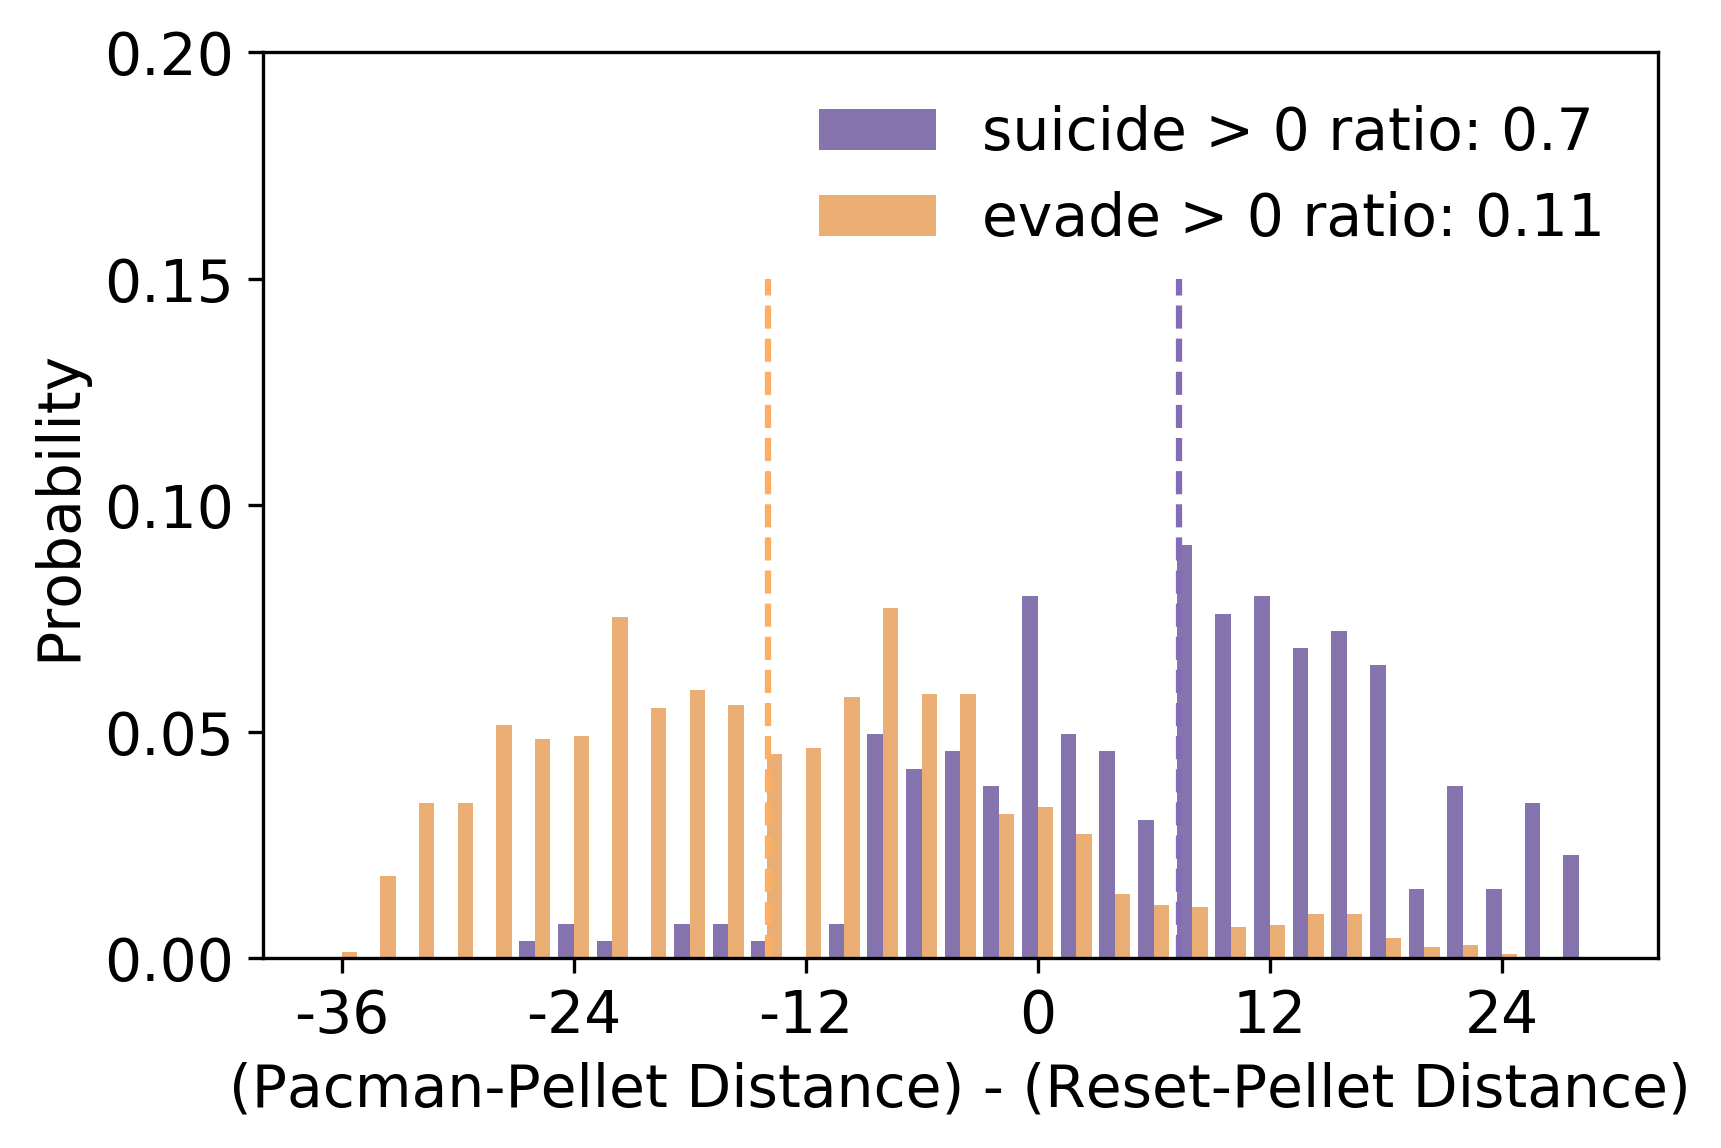

<IPython.core.display.Javascript object>

In [35]:
evade_suicide_start(df_reset_comb)

In [36]:
def evade_suicide_start_extend(df_total):
    evade_lists = list(
        filter(
            lambda x: len(x) >= 3,
            [
                list(i)
                for i in consecutive_groups(df_total[df_total.labels == "evade"].index)
            ],
        )
    )
    evade_indexes = [i[0] - 1 for i in evade_lists]

    suicide_lists = list(
        filter(
            lambda x: len(x) >= 3,
            [
                list(i)
                for i in consecutive_groups(
                    df_total[
                        (df_total.labels == "approach")
                        & (df_total["ifscared1"] < 3)
                        & (df_total.file == df_total.file.shift())
                    ].index
                )
            ],
        )
    )
    suicide_start_index = [
        i[0] - 1
        for i in suicide_lists
        if (df_total.loc[i, "distance1"].diff() > 0).sum() < 1
    ]
    df_plot_all = pd.DataFrame()
    for k, target_index in {
        "evade": evade_indexes,
        "suicide": suicide_start_index,
    }.items():
        df_plot = (
            pd.Series(target_index)
            .explode()
            .rename("target_index")
            .reset_index()
            .merge(
                df_total["distance1"]
                .reset_index()
                .rename(columns={"index": "level_0"}),
                left_on="target_index",
                right_on="level_0",
            )
            .groupby("index")["distance1"]
            .mean()
            .rename(k)
        )
        df_plot_all = pd.concat(
            [
                df_plot_all,
                pd.cut(
                    df_plot,
                    bins=range(int(df_plot.min()), int(np.ceil(df_plot.max())) + 1),
                    labels=list(
                        range(int(df_plot.min()), int(np.ceil(df_plot.max())) + 1)
                    )[1:],
                )
                .value_counts(normalize=True)
                .rename("value")
                .reset_index()
                .assign(category=k),
            ]
        )
    sns.set_palette([status_color_mapping["approach"], status_color_mapping["evade"]])
    df_plot_all = df_plot_all[df_plot_all["index"] < 25]
    ax = sns.barplot(
        data=df_plot_all.sort_values(by="index"), x="index", y="value", hue="category",
    )
    tks, labels = ax.get_xticks(), [i.get_text() for i in ax.get_xticklabels()]
    ax.set_xticks(tks[::6])
    ax.set_xticklabels(labels[::6])
    plt.legend(title=None)
    plt.xlabel("PacMan-Ghost Distance")
    plt.ylabel("Probability")
    plt.savefig("../analysis_pics_" + monkey + "/113_2.pdf")

<IPython.core.display.Javascript object>

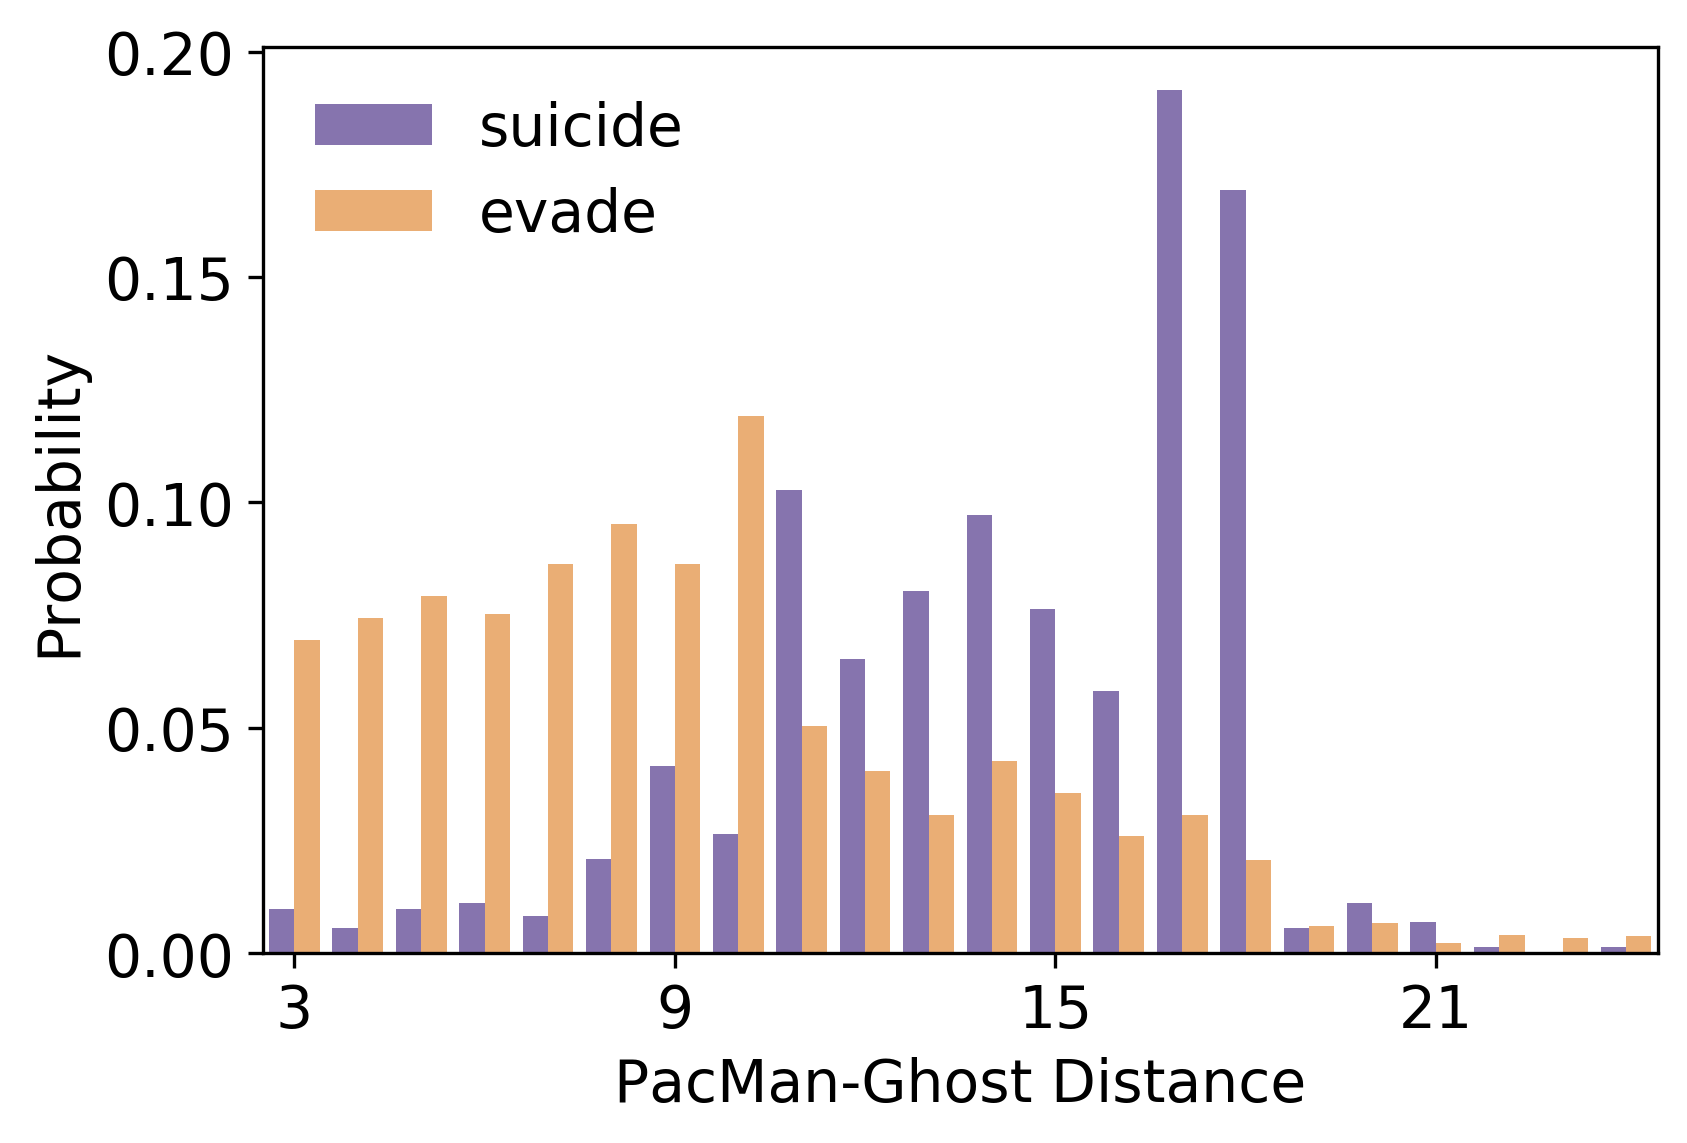

<IPython.core.display.Javascript object>

In [37]:
evade_suicide_start_extend(df_reset_comb)